# Car2Go Vehicle Positioning Optimisation

## Zachary Amar

# 1. Introduction

$\quad$ It is early July 2016 and the CEO of Car2go, Paul DeLong, is sitting at his desk reflecting on another year for the EV sharing program that will fit into the smart city goals to make urban habitats more efficient and more sustainable. Mr DeLong wishes to continue the Car2go program in San Diego and needs to plan his strategy for next year. He needs to change things around as Car2Go is currently failing to successfully satisfy customer demands while maintaining low operating costs and they are close to bankruptcy.

$\quad$ Paul decided to hire a team of data scientists, who were experts in optimization and Python, to help him solve the strategic and operational challenges that Car2go faces. In particular, he is trying to understand what the ideal placement and repositioning of EV's is in order to maximize the company's profits. This is quite a complicated task as he needs to understand his demand, make sure enough customers are satisfied and that the cars are always charged.

$\quad$ As the board of director's new Chief of Scientists, we will clearly lay out the steps taken to observe the past data given for San Diego, and use this information on demand and trip history to develop a model that will best fit the needs to satisfy demand and supply at the lowest cost.

# 2. Preliminary Data Analysis

### Step 1: Data Cleaning

$\quad$ The first step was obviously to import the data. Once that was done we observed what we had. We quickly realised that the data was not clean so step one of our data analysis is data cleanning.

$\quad$ **Step 1: Removing Unnecessary Columns**

$\quad$ The dataset had various columns that were of no use to us such as (but not limited to):
- the "origin" or "destination" columns since they were already broken down into longitude and latitude
- the "Total_TravelTime" column which did not make much sense
- the "time_gap" as it was duplicated etc ...

$\quad$ We therefore removed the columns we did not find any use for and were left with a simplified dataset containing information about the trips we had, their origin, destination and how much time they took. We also converted the hours to San Diego Hours. The columns origin and dest hours were actually the hours in the HeadQuarters, in Germany. The correct hour times were the SD_hr's which we then renamed origin and destination hours.

$\quad$ **Step 2: Removing "Nan" Values From the Dataset**

$\quad$ The next thing we did was check the integrity of the data. We quickly noticed that some of the columns contained "Nan" values, which are hard to deal with. When looking at the number of "Nan's", we realized there were not so many and we decided to simply remove the rows that were incomplete. Removing these rows will allow us to manipulate the data in an easier way.

$\quad$ **Step 3: Removing Outlier Trips**

$\quad$ Like in most data processing, the next step was the remove outliers. When looking at the columns we have, "travel.times" is our main quantitative column and thus we will try and remove any trips that seem to make no sense. By creating a `summary` function we were able to observe the max, min, mean and standard deviation of the column and the results were as followed:

- The maximum is: 1435 min (too long)
- The minimum is: 5 min
- The mean is: 75 min
- The standard deviation is: 185 min (high variability)

$\quad$ From this we can clearly see that there are outliers. A trip that lasts 1435 min (24h) does not make much sense for a single ride. After researching online, we realized that Car2go has the option to rent the car for a one or two days period in what they call packages. However, since these long duration trips are not important for us in terms of repositioning the hourly cars, we will exclude them. We also had to do something about the extremely high standard deviation. 

$\quad$ We therefore had to find a cut-off for the trips duration. From google maps, we saw that driving all across San Diego takes between 20 and 30 min. We also found out that San Diego suffers from heavy traffic. We therefore decided it would make sense to triple that time and set it as an upper limit. This is reasonable as the upper limit would be 90min and we saw the mean was 75. From the graphs (see further below), we can also see there are not many trips left after 60min anyways. 

$\quad$ We also decided there should be a lower limit (and exclude trips that have time 0) but the minimum was 5 min. We found it reasonable that someone took the car for a quick 5 min grocery run and decided we would not remove any trips on the lower end.

$\quad$ **Step 4: Removing Incomplete Days**

$\quad$ Finally, since we are going to deal with daily data, we had to make sure we only had complete days to avoid biasing certain hours. The initial data set went from *2014-03-06 20:46* to *2014-04-01 9:55*. This means we have the end of the day on the 6th of March and the beginning of the day on the 1st of April. To avoid problems in the future we only kept data between the 7th and the 31st of March, giving us 24 days of data.



### Step 2: Data Exploration

$\quad$ **Trips Duration Analysis**

$\quad$ Now that we have a clean dataset, the next step in the preliminary data analysis is to actually observe the data and see what interesting observations we could find. First, let's see what our trips duration looks like in a histogram now that we have filtered outliers.


<img src = "Trips Duration Hist.png" style = "width: 400px;"/>

<pre>
<center> Figure 1: Trips Duration Histogram - In Minutes </center>
</pre>


$\quad$ We can clearly see that there are not many trips more than one hour long, most of them last between 10 and 20 min, but a fair amount do last 30 to 40 min as well. We can also confirm that 90 was a good cutoff as there are not many trips left after. Finally, here are the new trip statistics:

- The maximum is: 85.0 - makes sense
- The minimum is: 5.0 - makes sense
- The mean is: 28.0 - makes sense
- The standard deviation is: 15.0 - much lower, we can use the mean no need for the median

$\quad$ **Popular Hours Analysis**

$\quad$ Now that we know how long trips last, let' take a look at what times they tend to occur at:

<img src = "popular hours.png" style = "width: 500px;"/>

<pre>
<center> Figure 2: Demand By Hour By Origin </center>
</pre>

$\quad$ From the plot above we clearly see what the popular hours are. First, as expected, the hours where people go and come back from work (7-8-9 and 17-18) are hours of high demand. After all, this is a form of "public" transport. It is however interesting to note that the most popular times of the day are 14,15,16h. This might mean that it is used a lot by high schoolers (in the USA most of them can drive) who go home for lunch or that leave school for extracurricular activities. It can also represent people going to meetings around the city during the day. We can also see that people do not use them that much at night, even if the metro does close at 22h, the demand does not go up.

$\quad$ **Popular Stations Analysis**

$\quad$ Our lowest level of granularity for this case will be at the zipcode level. Therefore, let's take a look at the popular and unpopular zips codes. The first analysis performed contrasted the origins and the destinations:

<table><tr>
<td> <img src = "Origin Zips.png" style = "width: 400px;"/> </td>
<td> <img src = "Destination Zips.png" style = "width: 400px;"/> </td>
</tr><table>

<pre>
<center>    Figure 3: Popular Origin Zip Codes                Figure 4 (Right): Popular Destination Zip Codes </center>
</pre>


$\quad$ The results from the above image are very curious: A station that is a popular origin is also a popular destination. A station that is a non-popular origin is also a non-popular destination. That would mean that a lot of the trips are probably round trips. This is excellent for us as we will have very little repositioning to do every hour and our costs will be low.

$\quad$ In order to check our hypothesis we pivoted the origins and destinations:

<img src = "Origin and Destination Top 10.png" width = 800px;/>

<pre>
<center> Figure 5: Origin and Destination Combinations </center>
</pre>


$\quad$ We can clearly see the most popular combinations are round trips. The diagonal of the table is usually big numbers. (We further analysed non round trips and nothing special came out of it. The same stations were popular/unpopular, just proportionately smaller as there are less non round trips.)

$\quad$ Now that we have all this information, let's map the stations we have and color them in terms of popularity:

- Green: high popularity
- Blue average popularity
- Red: low popularity

<table><tr>
<td> <img src = "StationMap.png" style = "width: 550px;"/> </td>
<td> <img src = "HeatMap.png" style = "width: 630px;"/> </td>
</tr><table>

<pre>
<center> Figure 6: Stations Mapping </center>
</pre>

$\quad$ From the map on the left, we can observe that there are two main zones: uptown and downtown. Downtown consists of the two red stations on the bottom of the map, showing us that people from the south of the city do not really use the product. Uptown on the other hand is where all the popular stations are. We have two greens on the upper left (near the ocean), and then a nice cluster of green and blue in the middle of city. We can only assume that is where most people go to work. There are also a couple blue stations on the left near the city airport, which makes sense as it is a great way to go to the airport without paying a cab or having to worry about parking there, and in the upper right, where San Diego University is.

$\quad$ From the map on the right, we can observe that the demand is most dense in the areas of green stations, which makes sense. However, we do see a couple of red stations in the middle of high demand zones: the first one is centre bottom, above coronado and the second one is middle left (near 2B-3-4A). This is surprising as the color of the station is based on its demand. This might mean that in the middle of these high demand zone, some zips are not popular. In fact, when we searched for a reason we realized these areas are full of parcs as well as near the harbour. This would explain why there are not many Car2Go users there. In the first case people would walk around instead of drive and in the second case, trucks would be more convenient.

$\quad$ To finish our stations analysis, let's look at what combination of stations have the longest trips:

<img src = "Times Taken Between Stations.png" style = "width: 250px;"/>

<pre>
<center> Figure 7: Top 10 Station Combinations in Terms of Average Drive Time </center>
</pre>


$\quad$ The results from this are very interesting. The least popular stations, 92123 for example, actually have the longest trips. We can also see that the popular stations are nowhere to be seen, therefore usually trips are short for them. This piece of information combined with the fact that we know most trips are round trips means that very little repositioning will have to be done during the day as cars reposition themselves automatically.

### Step 3: Demand Estimations

$\quad$ Based on trips information, we have to understand what our demand looks like. Our objective in this section is to be able to know for any given hour of any given day, how many trips go from a certain zip code to another.

$\quad$ From our previous section we saw that we have 24 days of data. We will therefore count how many trips are taken, grouping by origin zip, destination zip and hour of the day and divide the result by 24. For our model we will create a demand dictionary, however for this section we will present our data in a pivot table. The resulting table is too big to show therefore we will show for only one destination zip code.

<img src = "DemandTableSample.png" style = "width: 750px;"/>

<pre>
<center> Figure 8: Demand Table Sample dzip = 92101 </center>
</pre>

$\quad$ *Example on how to read this table:* from Zip code 92104 to 92101 at 22h there are 5 trips that are taken.


### Step 4: Revenue Estimations

$\quad$ After we found our demand, we needed to figure out how much we make per trip. After some research, we saw that Car2Go's price oscillates between 35 and 45 cents a minute. We are going to assume this depends on peak hours. We will put the higher tariffs at 7-8-9/17-18-19 (when people go and come back from work) as well as during lunch time: 14-15-16. We will also increase prices at night: 10pm to 6 am as most public transport costs increase during those times. From this price table we were able to match the hour of the trip to a price, which we multiplied by the trip duration giving us a revenue per trip column.

$\quad$ After averaging that column, we determined that the average revenue per trips is of: 11.67$

$\quad$ For the actual model however, in order to make the results more accurate, we will use a dictionary of prices (see coding section). We started by looking at the mean distance (time taken) between 2 zip codes $i\in Z$ and $j\in Z$. We then multiplied the average trip duration by 35 cents if t was in our low price moments and by 45 cents when t was in our high demand moments.

### Step 5: Cost Estimations

$\quad$ We applied the same logic to figure out how much a trip would costs us if we were repositioning the car. The salary per hour of a worker is of 10.8$ per hour, which leads to 0.18c per minute. From this we were able to determine the cost of each trip.

$\quad$ After averaging that column, we determined that the average revenue per trips is of: 5$

$\quad$ For the actual model however, in order to make the results more accurate, we will use a dictionary of prices. using 18 cents per minute (10.8 hourly wage) and multiplying that value by the average time it takes to go from zip $i\in Z$ to zip $j\in Z$.

$\quad$ For model 2, we will also consider cost of repositioning, creating a dictionary of the cost to go from zip $i\in Z$ to charger $c\in C$ (see coding section). We did not have to worry about the time in this case as workers are paid the same whatever the hour.


### Summary:

$\quad$ The dataset we obtained gave us information about trips taken in San Diego using Car2Go. We had information about the trip's origin and destination and the trips durations. After some data cleaning, where we removed "Nan" values and trips that lasted over an hour and a half, we were able to uncover the following facts:

1. Most trips last between 10 and 20 min or between 30 and 40 min, the mean is 28 min
2. Most trips are round trips, which means that popular origins are also popular destinations
3. The stations at the bottom of the city are unpopular while the ones uptown are most likely popular, especially near the beach, the city center, the airport and San Diego University
4. The unpopular stations usually have the longest trips and popular stations usually have shorter trips
5. People like to go to work more than they like coming back using Car2Go 
6. The most popular hours are during lunch time
7. Car2Go is not very used after 22h, which is surprising as that is when the metro closes
8. On average Car2Go makes 11.67$\$$ every trip
9. On average it costs Car2Go 5$\$$ for every repositioning
10. 92101 is the most popular zip code by far

$\quad$ All these facts will help us later in the managerial insights. For example, we expect very low repositioning of cars since most people travel within the same zip code
   

# 3. Linear Program Models

## Assumptions

Our model relies on the following assumptions:

1. All customers use the basic package, Smart cars and they do not take the weekend package to rent a car for a couple of days
2. There is no difference between the days of the week. The trend is very similar in terms of hours and while there is a slight difference in terms of overall demand, for this model we will not take it into account. We do hope that if the board accepts this model we will get access to a full year of demand, and in that case we will adjust for seasonality and even day of the week
2. Zip code is sufficient granularity to tackle this problem
3. The estimated average revenue per trip is 11.67$\$$
4. 10.8$\$$ is the hourly salary of car2go employees that reposition cars
5. We pay 0.18 cents per minute and not the full hour when repositioning vehicles
4. The average estimated cost of repositioning per trip is 5$\$$. 
5. It costs 2.64$\$$ to recharge an electric vehicle
5. The time taken by the employees to reposition the cars is negligible
5. All trips start and end at time t
6. We assume there is no budget constraint. Since a trip makes about twice the cost of repositioning a car, if the solver tells us to reposition a car, then we assume it is for a reason and that it will be used. That would be a profitable operation for us. Therefore, we will reposition as much as the solver tells us and not bother with a budget.
7. The EVs will always have enough energy to serve the trips and the repositioning until brought to a charging station
8. Due to low processing power, we will not force the results to be integers. This means that we will accept decimal amounts of cars to be moved around. We realize that is not correct but had no other choice.
9. 10% of EVs will need to be brought to charge
10. EVs take 4h to charge and will not be used once they are set to charge until fully charged


## Variable Definitions

### Sets
1. $Zips =\{91910, 91911, 92101, 92102 ...\}$: Zip code areas of San Diego
2. $Times =\{0,1,2,3,4,5,6,7,8,9,10,....22,23\}$: Hours of the day
3. $Chargers=\{92101,92107,92114\}$: Charging stations

### Parameters

1. **revenue_per_trip** = Average revenue per trip = 11.67$\$$
2. **cost_of_repostion** = Average cost of repositioning one vehicle = 5$\$$
3. **customer_satisfaction_level** = Minimum number of trips we guarantee to statisfy = 80%
5. **cars_available** = Number of cars in Car2Go owns in San Diego = 400
6. **percentage_of_cars_need_charging** = 10%
6. **cost_electricity** = Cost of fully charging an electric vehicle = 2.64$\$$
7. **$Demand_{ijt}$**: number of EVs past trips from data from zipcode $i\in Z$ to zip code $j\in Z$ at time $t\in T$ 
7. **$Price_{ijt}$**: price a customer will pay to go from zipcode$i\in Z$ to zip code $j\in Z$ at time $t\in T$
7. **$Costs_{ij}$**: cost for Car2Go to reposition a vehicle from zipcode$i\in Z$ to zip code $j\in Z$
7. **$CostRepositioning_{ij}$**: cost for Car2Go to bring a vehicle from zipcode$i\in Z$ to charger code $c\in C$


### Variables:

$\quad$ **State Variables**
1. $W_{it}$: number of EVs available at zipcode $i\in Z$ at time $t\in T$
2. $C_{ct}$: number of EVs at charging station $c\in C$ at time $t\in T$


$\quad$ **Control Variables**
1. $R_{ijt}$: number of EVs to reposition from zipcode $i\in Z$ to zipcode $j\in Z$ at time $t\in T$
3. $X_{ijt}$: number of EV trips from zipcode $i\in Z$ to zipcode $j\in Z$ at time $t\in T$ 
4. $N_{cit}$: number of EVs leaving charging station $c\in C$ to zipcode $i\in Z$ at time $t\in T$
6. $M_{ict}$: number of EVs bring from zipcode $i\in Z$ to charging station $c\in C$ at time $t\in T$




## Model 1

### Objective Function

$\quad$ The objective of any company is to maximize profits. This is why our objective will be to maximize the profits that Car2Go can make. We will therefore take all the trips from zipcode $i\in Z$ to zipcode $j\in Z$ at time $t\in T$ and multiply them by the price we charge between these zip codes at a given time and subtract the repositioning costs we have for the two zip codes:

$$\max\sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(X_{ijt}\times Price_{ijt} - R_{ijt}\times Cost_{ij})$$

### Constraints

*1. The first constraint we have is related to the number of vehicles at any given time $t$ and zip code $i$. This will allow us to know how many vehicles each zip has at any moment. To determine this, we set it equal to the number of cars left from the previous $t$ minus the cars that car that left the stations, plus the cars that have arrived naturally. We also remove the cars we have repositioned to another station and add the ones we have repositioned to this station. In mathematical terms it is the following:*


$$W_{it} = W_{it-1}-\sum_{i\in Z}X_{ijt}+\sum_{j\in Z}X_{jit}-\sum_{i\in Z}R_{ijt}+\sum_{j\in Z}R_{jit}, \quad \forall t\in T$$


*2. The next constraint we have is related to the amount of vehicles we must provide at any given time for any zip code. Thanks to the demand table we know how many vehicles will be demanded at any given time between two zip codes i and j. We will have to make sure that $X_{ijt}$ is in between the minimum satisfaction level but not above the actual demand level as it would be a waste. In mathematical terms it is the following:*

$$X_{ijt} \geq D_{ijt}\times CustomerSatisfactionLevel$$


$$X_{ijt} \leq D_{ijt}$$

*3. The third and final constraint makes sure that we do not use too many vehicles. We only have 400 and thus have to make sure that at any given time, the sum of vehicles is less than or equal to the number of cars available. For this case let's do it for time 0. In mathematical terms it is the following:*

$$\sum_{i\in Z}W_{i,0} \leq CarsAvailable$$


*4. All variables need to be greater or equal to 0 as we cannot have negative cars.*

$$R_{ijt} \geq 0 \quad \forall i\in Z \quad \forall j\in Z \quad \forall t\in T$$

$$W_{it} \geq 0 \quad \forall i\in Z  \quad \forall t\in T $$

$$X_{ijt} \geq 0 \quad \forall i\in Z \quad \forall j\in Z \quad \forall t\in T $$



### Results

$\quad$ Now that we a have model let's take a look at our results.

**Total Profits:** 7722.44$\$$ per day, 2.8M a year

**X - Trips between two zip codes at a time t we satisfy**

$\quad$ First, let us look at variable X, or the number of trips between 2 zip codes at a given time t. In Figure 9, the X-axis represents the zip code number (on top is the origin and on the bottom the destination) and the Y-axis represents the hour or departure or arrival. The more dense blue means that more cars arrive or leave at those times. As we can see, 92101 is clearly the most popular zip followed by 92103. This makes sense as it is highly consistent with our demand count per zipcode.

$\quad$ It is also interesting to note that some zip codes are more popular in specific times of the day. 92102 for example is very much used in the very early mornings (4-5am) while 92109 is used late at night, from 23 to 2am. Finally zip code 92116 is very used in the middle of the day (see how blue darkens from 15 to 17h).


$\quad$  A full view of the results can be found in the heat maps of Figure 9:

<img src = "X _Model1_Heat1.png" style = "width: 700px;"/>
<img src = "X _Model1_Heat2.png" style = "width: 700px;"/>

<pre>
<center> Figure 9: Result Heat Map Variable X </center>
</pre>



**W - Number of cars in a specific zip code at a time t**

$\quad$ Next, let's take a look at variable W, or the number of vehicles in a specific station at a specific time. There appears to be many cars available at location: 92101, during the morning (Midnight - 6am). This suggests that it is one of the locations with the most active Car2Go users. Along with zipcodes: 92102, 92107, 92116, a high number of electric vehicles (double digits) are to be made available in these popular stations to satisfy their respective demand. When compared with our original analysis regarding the demand of trips originating from specific zipcodes, our model suggests a logical allocation of EV cars where popular stations are more heavily supplied in EVs than less popular ones. 

$\quad$ A full view of the results can be find in Figure 10:

<img src = "W _Model1_table.png" style = "width: 600px;"/>

<pre>
<center> Figure 10: Result Table Variable W </center>
</pre>

**R - Repositioned cars between two zip codes at a time t we satisfy**

$\quad$ Finally, let us look at variable R, or the number of cars repositioned between 2 zip codes at a given time t. As expected, there is a low number of repositioning needed. As stated before, most trips are round trips, and the trips in non popular stations are the longer ones. This means that there will be short round trips in the popular areas.

$\quad$ Observing the results table below, we can see that the destination where the most cars (5) are repositioned to is zipcode: 92104, followed by 92103 and 92102 (2). This suggests that the repositioning of cars should not be focused on the most popular zipcode locations as cars will be initially placed in this location. Instead, cars should be repositioned to areas that will be relatively less popular but still require a high number of available EVs to satisfy customer demand. 

$\quad$ It is also interesting see that a lot of the relocation occurs during the midday from zipcode 92107.  This might suggest that that specific zip code has too many vehicles after a busy morning and they are not needed for the afternoon, while the other zips do.

$\quad$ A full view of the results can be find in Figure 11:

<img src = "R _Model1_table.png" style = "width: 400px;"/>

<pre>
<center> Figure 11: Result Table Variable R </center>
</pre>


## Model 2

### Objective Function

$\quad$ In this more complex model, we will have a similar objective function as in Model 1 (maximize profits) but will include the new costs of charging: Both the cost to repositioning to and from a charging station and the cost of electricity.

$$\sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(X_{ijt}\times Price_{ijt} - R_{ijt}\times Costs_{ij}) $$

$$ - \sum_{i\in Z}\sum_{c\in C}\sum_{t\in T}(M_{ict}\times CostRepositioning_{ic} + M_{ict}\times CostElectricity) $$

$$ - \sum_{i\in Z}\sum_{c\in C}\sum_{t\in T}N_{cit}\times CostRepositioning_{ic}$$

### Constraints

*1. The first constraint we have is related to the number of vehicles at any given time $t$ and zip code $i$. It is very similar to the one in Model 1, but we also remove the cars going to the charging station and add the ones that we bring back to that zipcode. In mathematical terms it is the following:*

$$W_{it} = W_{it-1}
-\sum_{i\in Z}X_{ijt}
+\sum_{j\in Z}X_{jit}
-\sum_{i\in Z}R_{ijt}
+\sum_{j\in Z}R_{jit}
-\sum_{c\in C}M_{ict}
+\sum_{c\in C}N_{cit}, \quad \forall t\in T $$

*2. The next constraint we have is related to the amount of vehicles we must provide at any given time for any zip code. It is exactly the same as in Model 1.*

$$X_{ijt} \geq D_{ijt}\times CustomerSatisfactionLevel$$

$$X_{ijt} \leq D_{ijt}$$

*3. The third constraint makes sure that we do not use too many vehicles. The only difference with the previous Model is that we take the number of cars in the charging stations into account. In this case we check for time 0. In mathematical terms it is the following:*

$$\sum_{i\in Z}W_{i0} \leq CarsAvailable - \sum_{c\in C}C_{c0}$$

*4. The first new constraint we have is related to inventory of vehicles at the charging station at any given time $t$ and station $c$. To determine this, we set it equal to the number of cars left in the previous $t$ plus the cars that arrived at the charging station and minus the cars we bring back to a zipcode at time $t$. In mathematical terms it is the following:*

$$C_{ct} = C_{ct-1}
+\sum_{c\in C}M_{ict}
-\sum_{c\in C}N_{cit},\quad \forall t\in T $$

*5. We then have a constraint for number of cars we need to bring to a charging station. In this case we need to move 10% of EVs that customers drop off in any zip code to a charging station. Therefore, we set the sum of total cars brought to any charging station equal to 10% of EV trips customers have taken. In mathematical terms it is the following:*

$$\sum_{c\in C}M_{ict}=0.1\times\sum_{j\in Z}X_{jit},\quad \forall t\in T$$

*6. The last constraint we have looks at the number of cars that we bring back to any zipcode at time $t$. We set the total number of vehicles brought back to a customer zip equal to sum of the vehicles that arrived at the station four hours ago. In mathematical terms it is the following:*

$$\sum_{i\in Z}N_{cit}=\sum_{i\in Z}M_{ict-4},\quad \forall t\in T$$

*7. All variables need to be greater or equal to 0 as we cannot have negative cars.*

$$R_{ijt} \geq 0 \quad \forall i\in Z, \forall j\in Z, \forall t\in T$$

$$W_{it} \geq 0 \quad \forall i\in Z, \forall t\in T $$

$$X_{ijt} \geq 0 \quad \forall i\in Z, \forall j\in Z, \forall t\in T $$

$$M_{cit} \geq 0 \quad \forall c\in C, \forall j\in Z, \forall t\in T$$

$$N_{ict} \geq 0 \quad \forall i\in Z, \forall c\in C, \forall t\in T $$

$$C_{ct} \geq 0 \quad \forall c\in C, \forall t\in T $$


### Results



$\quad$ Now that we have a model let's take a look at our results. 

**Total Profits:** 6960.82 $\$$, 2.5M yearly; slightly less than Model 1, makes sense as we added costs

**X - Trips between two zip codes at a time t we satisfy**

$\quad$ First, let us look at variable X, or the number of trips between 2 zip codes at a given time t. From the output, we can see that just like with the previous model where trips are most prominent with zipcode: 92101 (the most popular destination) along with zip code: 92103 also being a common destination. It is also interesting to see that zip code 92116 is mostly used in the afternoon and at night (starting at 2pm).

$\quad$  An easier way to see this would be to look at the heat maps below.

<img src = "X _Model2_Heat1.png" style = "width: 700px;"/>
<img src = "X _Model2_Heat2.png" style = "width: 700px;"/>

<pre>
<center> Figure 12: Result Heat Map Variable X </center>
</pre>

$\quad$  The X-axis represents the zip code number (on top is the origin and on the bottom the destination) and the Y-axis represents the hour or departure or arrival. The more dense blue means that more cars arrive or leave at those times.


**W - Number of cars in a specific zip code at a time t**

$\quad$ Next, let's take a look at variable W, or the number of vehicles in a specific station at a specific time. Interestingly, there are several observable differences in the number of Electric vehicles available. They have been more distributed across zip codes and less accumulated at 92101 (Center of San Diego City). There could be several explanations for this regarding the newly added constraints. As 10% of EVs require a necessary charge of 4 hours, they are redistributed by the solver to other zip codes automatically.

$\quad$ It is also very interesting to see that station 92104 is one which is usually filled up in the morning and then not used at night. It might be used by people to go to work, but that like to stay in the city or decide to go back home by public transport. This is quite the opposite form 92107, which is a lot more filled at night (19-23h). Probably a station for cars that are used after the metro closes at 22h. 

$\quad$ A full view of the results can be find in Figure 13:

<img src = "W _Model2_table.png" style = "width: 600px;"/>

<pre>
<center> Figure 13: Result Table Variable W </center>
</pre>

**R - Repositioned cars between two zip codes at a time t we satisfy**

$\quad$ Third, let us look at variable R, or the number of cars repositioned between 2 zip codes at a given time t. In this model there is even less repositioning than before. Some slight repositioning needs to be done in the early mornings to make sure everyone can have their cars for the day, but not more than 4 are ever repositioned. This makes sense as 10% of the trips go to charging stations and are brought back to zip codes that need cars. Therefore the repositioning happens automatically by going through a charging station.

$\quad$ A full view of the results can be find in Figure 14:

<img src = "R _Model2_table.png" style = "width: 350px;"/>

<pre>
<center> Figure 14: Result Table Variable R </center>
</pre>

**C - Number of vehicles in a charging station at time t**

$\quad$ Now, let us look at variable C, or the number of cars in a given charging station at a given time. The first and obvious thing we see is that charging station 92101 is the most used one. This makes sense as it in the center of San Diego, and is therefore the cheapest (closest) station for most cars, especially since most trips happen in zip code 92101. The next closest one is apparently 92114, which is not a usable zip code but probably close enough to the city for it to make sense. Finally charging station 92107 is used very little, probably by cars that are already in that region.

$\quad$ In terms of the numbers, full view of the results can be found in Figure 15, but they are pretty consistent with the demand pattern. More cars during the day less during the night. 

<img src = "C _Model2_table.png" style = "width: 600px;"/>

<pre>
<center> Figure 15: Result Table Variable C </center>
</pre>


**M - Trips from a zip code to a charginf station at time t**

$\quad$ Fifth, let us look at variable M, or the number of trips from a zip code to a charging station. From the heat map in Figure 16, we can see around what time each station sends cars to charge. It is curious to note that the amounts are pretty similar at any time (same density of blue). Once again station 92101 is the most popular, followed by 92103 and 92109. It is however interesting to note that station 92108 is probably a residential area as it charges the cars early in the morning for them to be available for people to go to work. On the other hand, 92103 is used all night.

<img src = "M _Model2_Heat.png" style = "width: 700px;"/>

<pre>
<center> Figure 16: Result Heat Map Variable M </center>
</pre>


**N - Trips from a charging station to a zip code at time t**

$\quad$ Finally, let's take a look at variable N, or the number of vehicles going from charging stations to zip codes at time t. Each table in Figure 17 represents the number of vehicles going from a charging station (First Column) to a customer Zip Code (Other columns). Based on each individual tables, we can see that charging station 92114 distributes EVs to the most distinct amount of zip codes. However, charging station 92101 distributes the largest amount of EVs, due to its close proximity with locations of high demand. As expected, EVs are sent to the same zipcode as the charging station when possible as it reduces the costs.

$\quad$ A full view of the results can be find in Figure 17:

<table><tr>
<td> <img src = "N _Model2_table1.png" style = "width: 200px;"/> </td>
<td> <img src = "N _Model2_table3.png" style = "width: 295px;"/> </td>
<td> <img src = "N _Model2_table2.png" style = "width: 264px;"/> </td>
</tr><table>

<pre>
<center> Figure 17: Result Table Variable N </center>
</pre>




# 4. Sensitivity Analysis

## Analysis 1: Loss of Cars from Flood Damage

$\quad$ Now that we have a fully functioning model, we will start with our sensitivity analysis. The first one we will look at is what happens if our cars get damaged. The reason we chose this topic is because there have been many flash floods in San Diego. It is therefore important for management to take into account the number of cars they will lose. EV’s may be significantly damaged or rendered completely unusable after flooding occurs. We will therefore look at what happens if we change the number of cars available. To do so we will assume 10% of the vehicles of the city will be damaged and therefore not usable. We will also attempt to find the lowest number of cars needed in order to satisfy the demand.

**Results**

$\quad$ After coding the sensitivity analysis, we realised that we have too many EVs. In fact, even after a flood, with 90% of the vehicles remaining we can still satisfy the constraints we set to our model and make the same amount of profits. What is even more surprising is that we can satisfy the constraints of our model and make the same amount of profits even with 15% of the vehicles. We have to lose 86% of our cars before our daily profits start going down (from 6960.82$\$$ to 6955.26$\$$), and even then we only lost about 5$\$$. Finally, we are only unable to satisfy 80% of the demand once we cut down our vehicle fleet to 4% of what we currently have.

$\quad$ This information is crucial to the managers at Car2Go. While they currently have 400 cars, only 14% of them are needed to satisfy the demand and make as much profits as right now and only 5% of them are needed to satisfy 80% of the demand. They are therefore pretty safe when it comes to flooding and loss of vehicles. 

$\quad$ We do however recommend they look into removing part of the cars from the streets to avoid potential damage to cars that are probably not being used, and use the excess inventory to replace damaged ones, cars that get in accidents stolen cars etc. Furthermore, if Car2Go is ever in a low cash situation, they could sell EVs. These cars start selling at 25K and selling them could get some cash back into the company.


## Analysis 2: Increased Wage Cost

$\quad$ In our last meeting with Mr. DeLong, he asked us to investigate how a change in salary will affect his profits. He obviously knows they will go down, but he wants to understand by how much. He is getting huge pressure from the union to increase the salaries of people who reposition cars as it is too close to minimum wage for such a tiring job. The workers are demanding an hourly wage increase from 10.8$\$$ to 12$\$$

**Results**

$\quad$ After coding the sensitivity analysis, Mr. DeLong can now see how any wage change will affect his profits. In the case that union is requesting an increase to 12$\$$ per hour, his profits will go down from 6960.82$\$$ to 6919.66$\$$. This represents less than a 1% decrease in overall profits for car2go, while making both the union and the workers happy. This might lead even lead to more profits through lower costs. We did not measure that change, but an increase in wages might lead to an increase in productivity or even in more care by the workers when dealing with the Car2Go cars. This might lead to them being more careful and not damaging the vehicles as much.

## Analysis 3: Removal of Unpopular Zips

$\quad$ We decided to conduct our third sensitivity analysis on the elimination of unpopular zip codes. Considering the costs of making our service available in a zip code such as maintenance and repositioning, we wondered whether removing the stations in zip codes that have the least trips or demand would improve our profitability since our main costs come from the repositioning of vehicles. Usually these come from unpopular zips to popular zips. If we restrict Car2go to only popular zip codes then maybe we will be able to increase profits.

**Results**

$\quad$ After coding the sensitivity analysis, we realised that removing zip codes is not a good idea. By removing the 5 least popular zip codes, we lowered our profits from the initial 6960.82$\$$ to 6950.65$\$$. In retrospect that makes sense. A repositionment will cost on average less than what we make in a trip. Therefore, if we reposition a vehicle to a location (to make sure a customer can make a trip) we will gain more than we lose.

$\quad$ Following this logic, we believe Car2Go should try and expand throughout the city. As we do not have information about what demand would be like in new zips, we will not be able to code this. But, we strongly believe that if Car2Go allowed people to go a little further in the suburbs when they dropped off a car, they would be more successful.

$\quad$ However, this only works for 2 reasons: first we use zip as the lowest level of granularity. In reality if we used stations, there would be a lot more repositioning and probably more costs. Second and most importantly, we do not consider car damage, accidents, and theft in this project. If there were bad zip codes, not only because of low demand but also because they are in more risky areas and the model took that into account, removing some of those zips which cost more than they bring in terms of car damage could be a good idea. This will be left to the management team to decide.


# Managerial Inisights


$\quad$ Now that we have all this information let's summarize it:

- **Optimal solution:**
    - In model 1, Car2Go will be able to make 7722.44$\$$ on a daily basis by satisfying at least 80% of all the demand (2.8M Yearly)
    - In model 2, Car2Go will be able to make 6960.82$\$$ on a daily basis by satisfying at least 80% of all the demand (2.5M Yearly)
    - As expected, due to high amounts of round trips and the fact that most long trips are between unpopular stations, there is very little repositioning to do. There is even less repostioning to do in model 2 as most cars go through a charging station and are then repositioned.
    - 92101 is the most popular zip code


- **Sensitivity analysis:**
    - Car2Go have way too many vehicles. They should probably store, 80% of them (only 14% are needed so 20% should be enough to have a buffer and make sure if there is extra demand Car2Go does not lose money) in case a flood occurs as they would already have vehicles to replaces damaged ones.
    - Car2Go could even sell some vehicles if they are ever in need of cash
    - Car2Go is able to increase the salary of workers without suffering too important losses. In fact we believe they should as it would boost team morale and workers might get even more efficient.
    - Car2Go should try and expand to different areas as the more they cover the more they will make. Furthermore they would not need to invest in extra vehicles as they already have to many.


# 5. Model Extension


$\quad$ The last part of this report will deal with a model extension. Until now, we have built 2 models, one simple and one a little more complicated one. However, there are still a lot simplifications and assumptions in these models and now we will try and make it even more realistic. We will look at potential costs and situations that we had not taken into account.

**Limit number of cars charging at a station at the same time**

$\quad$ The first and obvious simplification is that in our second model we assume that the three charging stations have unlimited capacity to charge as many cars as possible. However, we know that is physically impossible, therefore we decided to put a limit to the number of cars that can be charging at a specific station at the same time. We will assume that 10 cars per station at any given time will be the limit. When looking online we saw that is usually how many chargers are in a station. This should not be too much of a problem as we saw in the results of Model 1 (Figure 15) there are rarely more than 10 vehicles in a station at a given time.

**Car replacement over time due to use**

$\quad$ Next we will deal with another issue we have not faced yet. In this kind of services, cars need to be replaced on a regular basis in order to provide the best service possible to the customers. Every certain number of trips, an old car is taken out of service and sold at a discounted price. Then a new one is bought to replace it. Usually cars go for 50% of the initial price. Our experts have assumed that every 10K trips a car needs to be replaced. 

$\quad$ Most trips last about 20 min. If a car is going at 30km per hour then in 20 min it goes through 10km. We will assume a car can go through 100K km before needing replacement, so an average a car needs to be replaced every 10K trips.

$\quad$ This means that every 10K trips we need to buy a new vehicle which costs 25K and we sell them for 12.5K (half price).

**Car replacement over time due to accidents**

$\quad$ Finally, we will keep looking at car replacements but will consider that fact that some cars will suffer accidents. From the city statistics we have found out that 1 in every 10K cars will get into an accident. Therefore, every 10K trips we have we need to add the price of car minus 5K of salvage value that the pieces are worth.


### Extra Parameters

$\quad$ For this section we will need a few more parameters.

1. **car_cost** = Cost of buying a new car = 25 000 (https://www.kbb.com/smart/fortwo-electric/)
2. **car_sold** = Revenue made from selling a car after 10K trips = 12500 (Dealers sell cars for 50% when they feel the need to replace it)
3. **car_salvaged** = Revenue from car after an accident = 5000 (extra pieces, scraps of metal, gears etc)
4. **trips_a_car_can_take** = number of trips a car can take before needing to be replaced = 10 000
5. **pct_of_cars_in_accident** = number of cars that get in an accident = 1/10 000
6. **station_capacity** = maximum number of cars in a station at one time = 10

### Objective Function

$\quad$ Now that we have all this information, let's build the new model, starting with the objective function. The objective of any company is to maximize profits:

$$\sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(X_{ijt}\times Price_{ijt} - R_{ijt}\times Costs_{ij}) $$
$$ - \sum_{i\in Z}\sum_{c\in C}\sum_{t\in T}(M_{ict}\times CostRepositioning_{ic} + M_{ict}\times CostElectricity) $$
$$ - \sum_{i\in Z}\sum_{c\in C}\sum_{t\in T}N_{cit}\times CostRepositioning_{ic} $$

$$- \sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(\dfrac{X_{ijt}}{TripsACarCanTake})\times (CarCost-CarSold)$$
$$- \sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(\dfrac{R_{ijt}}{TripsACarCanTake})\times (CarCost-CarSold)$$
$$- \sum_{i\in Z}\sum_{c\in C}\sum_{t\in T}(\dfrac{M_{ict}}{TripsACarCanTake})\times (CarCost-CarSold)$$
$$- \sum_{c\in C}\sum_{i\in Z}\sum_{t\in T}(\dfrac{N_{cit}}{TripsACarCanTake})\times (CarCost-CarSold)$$


$$- \sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(X_{ijt}\times PctOfCarsInAccident)\times (CarCost-CarSalvaged)$$
$$- \sum_{i\in Z}\sum_{j\in Z}\sum_{t\in T}(R_{ijt}\times PctOfCarsInAccident)\times (CarCost-CarSalvaged)$$
$$- \sum_{i\in Z}\sum_{c\in C}\sum_{t\in T}(M_{ict}\times PctOfCarsInAccident)\times (CarCost-CarSalvaged)$$
$$- \sum_{c\in C}\sum_{i\in Z}\sum_{t\in T}(N_{cit}\times PctOfCarsInAccident)\times (CarCost-CarSalvaged)$$

$\quad$ From this we can see that we start by adding the revenue we have, to that we subtract the repositioning cost from R, the repositioning costs from M, the repositioning costs from N and the electricity costs. We also remove a portion of the costs of a car every trip due to accidents and/or use.


### Constraints

*1. Zip Code Inventory Constraint (see explanation in earlier model)*


$$W_{it} = W_{it-1}
-\sum_{i\in Z}X_{ijt}
+\sum_{j\in Z}X_{jit}
-\sum_{i\in Z}R_{ijt}
+\sum_{j\in Z}R_{jit}
-\sum_{c\in C}M_{ict}
+\sum_{c\in C}N_{cit}, \quad \forall t\in T $$


*2. Demand Constraint (see explanation in earlier model)*

$$X_{ijt} \geq D_{ijt}\times CustomerSatisfactionLevel$$
$$X_{ijt} \leq D_{ijt}$$

*3. Cars Available Constraint (see explanation in earlier model)*

$$\sum_{i\in Z}W_{i0} \leq CarsAvailable - \sum_{c\in C}C_{i0}$$

*4. Charger Invetory Constraint (see explanation in earlier model)*

$$C_{ct} = C_{ct-1}
+\sum_{c\in C}M_{ict}
-\sum_{c\in C}N_{cit},\quad \forall t\in T $$

*5. Number of Cars that need charging constraint (see explanation in earlier model)*

$$\sum_{c\in C}M_{ict}=0.1\times\sum_{j\in Z}X_{jit},\quad \forall t\in T$$

*6. Number of cars we bring back from zip codes constraint (see explanation in earlier model)*

$$\sum_{i\in Z}N_{cit}=\sum_{i\in Z}M_{ict-4},\quad \forall t\in T$$

*7. This is the new constraint we are adding. This looks at how full a charging station is, and will not allow more than 10 cars at a time to be in one specific station.*

$$C_{ct} \leq Limit Cars Charging \quad \forall c\in C,  \forall t\in T$$

*8. All variables need to be greater or equal to 0 as we cannot have negative cars.*

$$R_{ijt} \geq 0 \quad \forall i\in Z, \forall j\in Z, \forall t\in T$$

$$W_{it} \geq 0 \quad \forall i\in Z, \forall t\in T $$

$$X_{ijt} \geq 0 \quad \forall i\in Z, \forall j\in Z, \forall t\in T $$

$$M_{cit} \geq 0 \quad \forall c\in C, \forall j\in Z, \forall t\in T$$

$$N_{ict} \geq 0 \quad \forall i\in Z, \forall c\in C, \forall t\in T $$

$$C_{ct} \geq 0 \quad \forall c\in C, \forall t\in T $$

### Results

$\quad$ When implementing the new constraints and costs in the model we see that the results change drastically. We went from being able to get 6960.82$\$$ to 4612.28$\$$. That represents a 33% decrease in daily profits. This goes to show how important it is to look at all the costs of a business. We do however beleive these numbers are much more accurate. This would lead to a yearly profit of 1.7M which is still not bad for a company going bankrupt.


# 6. Conclusion


$\quad$ Paul DeLong, Car2Go CEO gave us a mission. He tasked us with saving Car2Go from bankruptcy. He asked us to build a model that will maximize profits by optimizing the repositioning or EVs. In order for us to do so he gave us a data set of about 26K trips that occurred in San Diego. The first thing we did was clean up the data set. We removed useless or duplicated columns, cleaned up the time columns to the correct hour, removed trips that lasted too long and finally removed incomplete days of data.

$\quad$ With this clean dataset, we started looking at what insights we could get from the dataset. The first thing we looked at was trip duration. We saw that most trips last either between 10 and 20 minutes or between 30 and 40min. The average was 28 min with a standard deviation of 15 min. This was nice as the variation went from 185min (in the unclean data) to 15min. This shows us that Car2Go is used for small short trips within the city, and even traffic does not make the trips too long. Car2Go seems to be a popular method to commute to work in the morning and afternoon. However, it most used during the afternoon (13-14-15h), which lead us to believe it is an easy way to grab a lunch or go to a meeting during the day. 

$\quad$ After looking at the trip durations and time they were taken at we investigated the most popular stations. We saw that the city centre (92101) was the most popular one and the outskirts (92123) were the least popular one in terms of origins and destinations. However, the less popular a station have longer trips than popular stations. Finally, we uncovered that Car2Go users usually leave the car in the same zip code that they take it from (high number of round trips). 

$\quad$ The final step of our data exploration was looking at the average revenue and the average cost for Car2Go per trip. We used a variable price (35c per min when it was low demand and 45c per min when it was high demand) and a fixed cost (18c per min cost or 10,8 per hour). We obtained an average revenue of 11.67$\$$ per trip and an average cost of 5$\$$.

$\quad$ Based on all this information and all the assumptions stated above (Section 3) we build our models. 

- The first step was to define our parameters. We built:
    - 1 **Demand dictionary** (based on 2 zip codes and a time) 
    - 1 **Price dictionary** (based on 2 zip codes and a time) 
    - 2 **Costs dictionaries** (based on two zip codes for the first one and one zip code one charging station for the second one). 

$\quad$ In order to build the dictionaries we used a for loop with a `try` function which caught `KeyError` exceptions and set the values for which we had not information to the average values.

- The second step was to define the variables: X,W,R,C,M,N and their subscript
- The third step was to build the first model (no charging)
- The final step was to build the second model

$\quad$ The first model lead to yearly profits of 2.8M but did not include the charging stations while the second model lead to profits of 2.5M including both the cost to move vehicles to a charger and the cost of electricity, which we have estimated to be 2.64$\$$ per vehicle. From these models we saw that most of our cars need to be in zip code 92101 (city centre and the most popular by far) but also near the ocean, the airport and San Diego University. However, this model was too simple. There were a lot of assumptions we had done that we thought we could actually take into account. The obvious one being unlimited space at every charging station. We also had not considered the cost of replacing our vehicles over time due to overuse or even accidents. This is why we build a third model, in the Model Extension section, which took all these into account and modified the objective function and the constraints. With this third more accurate model we go to yearly profits of 1.7M, which is significantly less than the initial 2.5M but is a lot more realistic. Furthermore, it is not a bad result for a company nearing bankruptcy. 

$\quad$ San Diego is a city that suffers a lot from floods. We therefore looked into how sensitive we were to loosing vehicles. Statistically, about 10% of the vehicles get some damage from the floods, therefore we looked at what would happen is we only had 90% of our vehicles. It turns out Car2Go has way too many cars and can fully satisfy the current number of trips and make the same profit with 14% of the vehicles and they only need 5% to satisfy the 80% of the demand. This is why we recommend that they remove 80% (in order to have a cushion) of the vehicles from the streets in order to minimize losses in case of a flood or any other natural disaster. 

$\quad$ We also recommend that they increase the salary of the workforce to 12$\$$ per hour. This would lead to a loss in revenue of not even 1% but might boost the team's morale greatly. This will lead to more motivated employees who work faster and more efficiently and will be more careful with the cars they handle. Furthermore, it might get the unions to be less of a bother in an industry where they consider the treatment of employees despicable.

$\quad$ Car2Go should also try and expand to more areas. They have a profitable business in San Diego and way too many vehicles. If they placed some in the suburbs or areas where there are currently not cars maybe they could attract some new customer and expand their reach. As they usually make more on a trip than the cost of repositioning and charging, it will be an easy way to increase profits even more.

$\quad$ Car2Go has paid us to do a job and it is now done. Even if we cost them 3M, they will be able to make that back in less than 2 years instead of shutting down. We do however believe that if they want to go through with this project, they need to give us a more comprehensive dataset. We currently only have 24 days of data. If we would get a full year of data, we could have a more thorough analysis on the demand. Everyday is not really the same, and we are sure there is some seasonality in the demand throughout the months. By making a more accurate demand table we are sure we can build a dictionary that had $D_{ijtdm}$ where d and m are the day and the month. We can also build a forecasting model using predictive analytics and try and estimate next year's demand to know if we need more vehicles and plan ahead. 








# Coding Section

In [1]:
from gurobipy import *
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import math
import seaborn
import datetime
from IPython.display import HTML, display


## Datasets

In [2]:
trips = Table.read_table('EVtripsInformation.csv')
trips

car,Total_TravelTime,time_gap,ozip,dzip,origin,origin_address,origin_longitude,origin_latitude,destination,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,SD_hr,travel.times
6NE H639,0,40.1341,92102,92102,"[-117.14348,32.7168,0]","C St 2258, 92102 San Diego",-117.143,32.7168,"[-117.14348,32.71683,0]","C St 2258, 92102 San Diego",-117.143,32.7168,2014-03-27 5:55,2014-03-27 6:35,5,6,13,40.1341
6NE H639,0.00499051,35.1144,92116,92116,"[-117.14639,32.76152,0]","Park Blvd 4628, 92116 San Diego",-117.146,32.7615,"[-117.14636,32.76149,0]","Park Blvd 4626, 92116 San Diego",-117.146,32.7615,2014-03-11 7:10,2014-03-11 7:46,7,7,15,35.1144
6NE H639,0.750497,10.0618,92110,92110,"[-117.20891,32.74301,0]","Barnett Ave 2946, 92110 San Diego",-117.209,32.743,"[-117.20968,32.74364,0]","Cadiz St 2719, 92110 San Diego",-117.21,32.7436,2014-03-17 0:12,2014-03-17 0:23,0,0,8,10.0618
6NE H639,1.13427,30.1165,92101,92101,"[-117.16418,32.71254,0]","W G St 146, 92101 San Diego",-117.164,32.7125,"[-117.16282,32.71494,0]",Broadway Cir at Horton Plaza,-117.163,32.7149,2014-03-25 22:18,2014-03-25 22:48,22,22,6,30.1165
6NE H639,1.35621,15.0504,92106,92106,"[-117.21876,32.72785,0]","Laning Rd 2601, 92106 San Diego",-117.219,32.7278,"[-117.21785,32.73316,0]","Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,2014-03-21 8:42,2014-03-21 8:57,8,8,16,15.0504
6NE H639,1.65763,10.0348,92103,92103,"[-117.16143,32.75171,0]","4th Ave 4100, 92103 San Diego",-117.161,32.7517,"[-117.1719,32.74993,0]","W Washington St 954, 92103 San Diego",-117.172,32.7499,2014-03-28 0:54,2014-03-28 1:04,0,1,8,10.0348
6NE H639,1.85743,20.0851,92106,92106,"[-117.21785,32.73316,0]","Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,"[-117.21597,32.73822,0]","Roosevelt Rd, 92106 San Diego",-117.216,32.7382,2014-03-24 13:15,2014-03-24 13:35,13,13,21,20.0851
6NE H639,1.98084,10.0456,92101,92103,"[-117.17478,32.73299,0]","W Palm St 1428, 92101 San Diego",-117.175,32.733,"[-117.16939,32.73485,0]","Reynard Way 2849, 92103 San Diego",-117.169,32.7349,2014-03-13 3:01,2014-03-13 3:11,3,3,11,10.0456
6NE H639,10.0852,25.0839,92101,92107,"[-117.16282,32.71494,0]",Broadway Cir at Horton Plaza,-117.163,32.7149,"[-117.24575,32.74961,0]","Long Branch Ave 4891, 92107 San Diego",-117.246,32.7496,2014-03-25 23:23,2014-03-25 23:48,23,23,7,25.0839
6NE H639,10.0961,35.1636,92104,92101,"[-117.12957,32.73111,0]","30th St 2428, 92104 San Diego",-117.13,32.7311,"[-117.20459,32.72891,0]","Spanish Lndg, 92101 San Diego",-117.205,32.7289,2014-03-13 20:55,2014-03-13 21:30,20,21,4,35.1636


In [3]:
trips.num_rows

25873

## Examining spatial and temporal asymmetry of trip demands

### Step 1: Data Cleanning
#### Remove Unnecessary Columns
First off, let's start with removing the unnecessary columns from the dataset

In [4]:
trips2 = trips.select([0,3,4,6,7,8,10,11,12,13,14,17,16,18]).relabeled("SD_hr", "origin_hr")
trips2

car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,travel.times
6NE H639,92102,92102,"C St 2258, 92102 San Diego",-117.143,32.7168,"C St 2258, 92102 San Diego",-117.143,32.7168,2014-03-27 5:55,2014-03-27 6:35,13,6,40.1341
6NE H639,92116,92116,"Park Blvd 4628, 92116 San Diego",-117.146,32.7615,"Park Blvd 4626, 92116 San Diego",-117.146,32.7615,2014-03-11 7:10,2014-03-11 7:46,15,7,35.1144
6NE H639,92110,92110,"Barnett Ave 2946, 92110 San Diego",-117.209,32.743,"Cadiz St 2719, 92110 San Diego",-117.21,32.7436,2014-03-17 0:12,2014-03-17 0:23,8,0,10.0618
6NE H639,92101,92101,"W G St 146, 92101 San Diego",-117.164,32.7125,Broadway Cir at Horton Plaza,-117.163,32.7149,2014-03-25 22:18,2014-03-25 22:48,6,22,30.1165
6NE H639,92106,92106,"Laning Rd 2601, 92106 San Diego",-117.219,32.7278,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,2014-03-21 8:42,2014-03-21 8:57,16,8,15.0504
6NE H639,92103,92103,"4th Ave 4100, 92103 San Diego",-117.161,32.7517,"W Washington St 954, 92103 San Diego",-117.172,32.7499,2014-03-28 0:54,2014-03-28 1:04,8,1,10.0348
6NE H639,92106,92106,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,2014-03-24 13:15,2014-03-24 13:35,21,13,20.0851
6NE H639,92101,92103,"W Palm St 1428, 92101 San Diego",-117.175,32.733,"Reynard Way 2849, 92103 San Diego",-117.169,32.7349,2014-03-13 3:01,2014-03-13 3:11,11,3,10.0456
6NE H639,92101,92107,Broadway Cir at Horton Plaza,-117.163,32.7149,"Long Branch Ave 4891, 92107 San Diego",-117.246,32.7496,2014-03-25 23:23,2014-03-25 23:48,7,23,25.0839
6NE H639,92104,92101,"30th St 2428, 92104 San Diego",-117.13,32.7311,"Spanish Lndg, 92101 San Diego",-117.205,32.7289,2014-03-13 20:55,2014-03-13 21:30,4,21,35.1636


**Now let's take a look at the integrity of the data.**


We have realised that some of the columns contain "nan" values. There are however not that many of them thus we will simply remove them

In [5]:
# From the data below we can see there are a bunch of nan. Let's look more into this
trips2.where(np.isnan(trips2.column("origin_hr")))

car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,travel.times
6NE H644,92110,92103,"Tuscaloosa St 2641, 92110 San Diego",-117.204,32.7445,"6th Ave 3744, 92103 San Diego",-117.16,32.7459,2014-03-09 2:59,2014-03-09 3:29,nan,3,30.1234
6NE H649,92101,92109,"15th St 860, 92101 San Diego",-117.15,32.7143,"Devon Ct 783, 92109 San Diego",-117.251,32.7661,2014-03-09 2:04,2014-03-09 2:34,nan,nan,30.125
6RF N701,92101,92103,"Ash St 320, 92101 San Diego",-117.162,32.7199,"4th Ave 3840, 92103 San Diego",-117.162,32.7475,2014-03-09 2:54,2014-03-09 3:29,nan,3,35.144
6RF N702,92101,92101,"Kettner Blvd 1582, 92101 San Diego",-117.169,32.7218,"Union St 756, 92101 San Diego",-117.166,32.7132,2014-03-09 2:34,2014-03-09 2:49,nan,nan,15.062
6RF N703,92109,92101,"Mission Blvd 3328, 92109 San Diego",-117.252,32.7749,"9th Ave 970, 92101 San Diego",-117.157,32.7154,2014-03-09 2:54,2014-03-09 3:19,nan,3,25.1033
6RF N704,92103,92107,"Torrance St 626, 92103 San Diego",-117.169,32.7443,"Cable St 1918, 92107 San Diego",-117.249,32.7462,2014-03-09 2:29,2014-03-09 2:49,nan,nan,20.0825
6RF N740,92108,92108,"Mission Valley Rd, 92108 San Diego",-117.152,32.7777,"Camino del Este 2015, 92108 San Diego",-117.144,32.7705,2014-03-09 2:14,2014-03-09 2:49,nan,nan,35.1458
6RF N760,92101,92101,"W Beech St 620, 92101 San Diego",-117.168,32.7209,"State St 800, 92101 San Diego",-117.167,32.7136,2014-03-09 2:39,2014-03-09 2:54,nan,nan,15.0607
6RF N767,92109,92110,"Ingraham St 3727, 92109 San Diego",-117.237,32.7877,"Kurtz St 3459, 92110 San Diego",-117.209,32.7546,2014-03-09 2:34,2014-03-09 3:19,nan,3,45.1854
6RF N780,92106,92101,"Macaulay St 3188, 92106 San Diego",-117.227,32.7304,"India St 2180, 92101 San Diego",-117.17,32.7272,2014-03-09 2:24,2014-03-09 2:49,nan,nan,25.1026


In [6]:
trips3 = trips2.where(np.isnan(trips2.column("origin_hr")) == False)
trips4 = trips3.where(np.isnan(trips3.column("dest_hr")) == False)
trips4

car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,travel.times
6NE H639,92102,92102,"C St 2258, 92102 San Diego",-117.143,32.7168,"C St 2258, 92102 San Diego",-117.143,32.7168,2014-03-27 5:55,2014-03-27 6:35,13,6,40.1341
6NE H639,92116,92116,"Park Blvd 4628, 92116 San Diego",-117.146,32.7615,"Park Blvd 4626, 92116 San Diego",-117.146,32.7615,2014-03-11 7:10,2014-03-11 7:46,15,7,35.1144
6NE H639,92110,92110,"Barnett Ave 2946, 92110 San Diego",-117.209,32.743,"Cadiz St 2719, 92110 San Diego",-117.21,32.7436,2014-03-17 0:12,2014-03-17 0:23,8,0,10.0618
6NE H639,92101,92101,"W G St 146, 92101 San Diego",-117.164,32.7125,Broadway Cir at Horton Plaza,-117.163,32.7149,2014-03-25 22:18,2014-03-25 22:48,6,22,30.1165
6NE H639,92106,92106,"Laning Rd 2601, 92106 San Diego",-117.219,32.7278,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,2014-03-21 8:42,2014-03-21 8:57,16,8,15.0504
6NE H639,92103,92103,"4th Ave 4100, 92103 San Diego",-117.161,32.7517,"W Washington St 954, 92103 San Diego",-117.172,32.7499,2014-03-28 0:54,2014-03-28 1:04,8,1,10.0348
6NE H639,92106,92106,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,2014-03-24 13:15,2014-03-24 13:35,21,13,20.0851
6NE H639,92101,92103,"W Palm St 1428, 92101 San Diego",-117.175,32.733,"Reynard Way 2849, 92103 San Diego",-117.169,32.7349,2014-03-13 3:01,2014-03-13 3:11,11,3,10.0456
6NE H639,92101,92107,Broadway Cir at Horton Plaza,-117.163,32.7149,"Long Branch Ave 4891, 92107 San Diego",-117.246,32.7496,2014-03-25 23:23,2014-03-25 23:48,7,23,25.0839
6NE H639,92104,92101,"30th St 2428, 92104 San Diego",-117.13,32.7311,"Spanish Lndg, 92101 San Diego",-117.205,32.7289,2014-03-13 20:55,2014-03-13 21:30,4,21,35.1636


#### Removing Outlying Trips

After examining the dataset, we have data on 2 main subjects: The trip durations and the trip locations. In order to analyze the data we will look at both, starting with the duration of the trips. This will allow us to remove all the trips that are outliers in terms of being too lengthy and too short since they will not accurately contribute to our findings or model. 

In [7]:
# Let's start by looking at the maximum, the minimum, the standard deviation and the mean of the trip lengths. 
# In order to do so let's create a function that gives us all the information we want.

def summary (data):
    """Summary Stats: This function will give us the summary statistics for an array of data"""
    print("The maximum is: " + str(round(max(data))))
    print("The minimum is: " + str(round(min(data))))
    print("The mean is: " + str(round(np.mean(data))))
    print("The standard deviation is: " + str(round(np.std(data))))


In [8]:
summary(trips4.column('travel.times'))

The maximum is: 1435.0
The minimum is: 5.0
The mean is: 75.0
The standard deviation is: 185.0


We have researched the distance and time by car, to drive from the beggining point and end point of the length of San Diego which is approximately 20-30 min. We have also researched the traffic statistics which informed us that San Diego is one of the top cities most affected by traffic. Thus we decide to limit the trip times to a maximum of 90 minutes once taking these two important aspects into considerations. We know this makes sense since our data indicated the mean trip time was about 75 min.

It also makes sense exclude extremely short trips which would be irrelevant. However the minimum trip is 5 minutes which makes sense as a duration time to use a car2go thus we have reconsidered and decided there will therefore be no lower limit.

In [9]:
# Create the filtered dataset
trips5 = trips4.where('travel.times', are.below(90))

#### Remove Incomplete Days

After some exploration of the dates in the dataset, we have realised that some data days are incomplete. Since we will be using the data to determine demand, we need to only use complete days of data in order ot have the correct amount of days.

In [10]:
# See what the maximum and minimum dates are
max_day = max(trips5.column("origin_time"))
min_day = min(trips5.column("origin_time"))

print(max_day)
print(min_day)

2014-04-01 9:55
2014-03-06 20:46


We need to remove everything from april 1st and from march 6th

In [11]:
trips6 = trips5.where("origin_time", are.not_containing('2014-04-01'))
trips_clean = trips6.where("origin_time", are.not_containing('2014-03-06'))

# See what the maximum and minimum dates are now
max_day2 = max(trips_clean.column("origin_time"))
min_day2 = min(trips_clean.column("origin_time"))

print(max_day2)
print(min_day2)

2014-03-31 9:55
2014-03-07 0:01


In [12]:
#See our final set
trips_clean

car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,travel.times
6NE H639,92102,92102,"C St 2258, 92102 San Diego",-117.143,32.7168,"C St 2258, 92102 San Diego",-117.143,32.7168,2014-03-27 5:55,2014-03-27 6:35,13,6,40.1341
6NE H639,92116,92116,"Park Blvd 4628, 92116 San Diego",-117.146,32.7615,"Park Blvd 4626, 92116 San Diego",-117.146,32.7615,2014-03-11 7:10,2014-03-11 7:46,15,7,35.1144
6NE H639,92110,92110,"Barnett Ave 2946, 92110 San Diego",-117.209,32.743,"Cadiz St 2719, 92110 San Diego",-117.21,32.7436,2014-03-17 0:12,2014-03-17 0:23,8,0,10.0618
6NE H639,92101,92101,"W G St 146, 92101 San Diego",-117.164,32.7125,Broadway Cir at Horton Plaza,-117.163,32.7149,2014-03-25 22:18,2014-03-25 22:48,6,22,30.1165
6NE H639,92106,92106,"Laning Rd 2601, 92106 San Diego",-117.219,32.7278,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,2014-03-21 8:42,2014-03-21 8:57,16,8,15.0504
6NE H639,92103,92103,"4th Ave 4100, 92103 San Diego",-117.161,32.7517,"W Washington St 954, 92103 San Diego",-117.172,32.7499,2014-03-28 0:54,2014-03-28 1:04,8,1,10.0348
6NE H639,92106,92106,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,2014-03-24 13:15,2014-03-24 13:35,21,13,20.0851
6NE H639,92101,92103,"W Palm St 1428, 92101 San Diego",-117.175,32.733,"Reynard Way 2849, 92103 San Diego",-117.169,32.7349,2014-03-13 3:01,2014-03-13 3:11,11,3,10.0456
6NE H639,92101,92107,Broadway Cir at Horton Plaza,-117.163,32.7149,"Long Branch Ave 4891, 92107 San Diego",-117.246,32.7496,2014-03-25 23:23,2014-03-25 23:48,7,23,25.0839
6NE H639,92104,92101,"30th St 2428, 92104 San Diego",-117.13,32.7311,"Spanish Lndg, 92101 San Diego",-117.205,32.7289,2014-03-13 20:55,2014-03-13 21:30,4,21,35.1636


### Step 2: Data Exploration

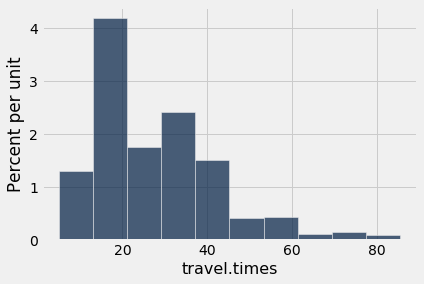

In [13]:
# Let's see what our trips look like in a histogram now that we have filtered our
trips_clean.hist('travel.times')

In [14]:
summary(trips_clean.column('travel.times'))

The maximum is: 85.0
The minimum is: 5.0
The mean is: 28.0
The standard deviation is: 15.0


We can clearly see that there are not many trips above one hour long, most of them last between 10 and 20 min, but a fair amount does last 30 to 40 min as well

Now, let's take a look at the orgin and destination zip codes and determine which are the popular ones:

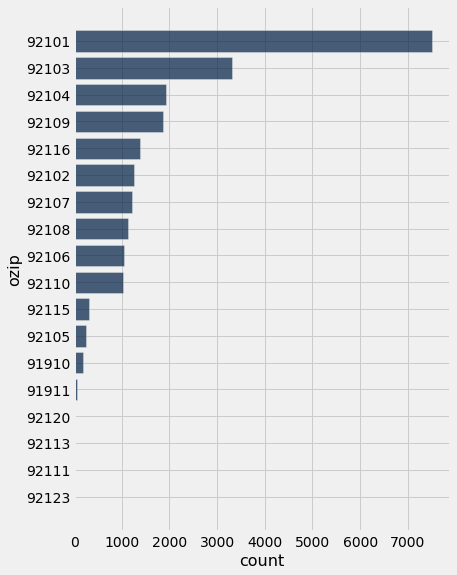

In [15]:
# Origin
trips_clean.group('ozip').sort('count',descending = True).barh('ozip','count')

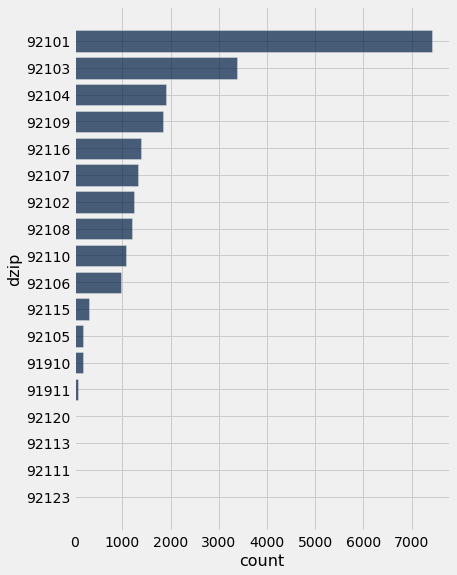

In [16]:
# Destination
trips_clean.group('dzip').sort('count',descending = True).barh('dzip','count')

This is very curious: A station that is a popular origin is also a popular destination. A station that is a non popular origin is also a non popular destination.

Let's dig deeper:

In [17]:
#Let's take a look at the common origin and destination pairs:
trips_clean.group([1,2]).sort('count',descending = True)

ozip,dzip,count
92101,92101,3438
92101,92103,1190
92103,92101,1139
92103,92103,924
92109,92109,783
92101,92102,578
92102,92101,561
92104,92101,484
92101,92104,468
92109,92101,434


In [18]:
trips_clean.group([1,2]).pivot("ozip", "dzip", values = "count", collect = np.sum).show()

dzip,91910,91911,92101,92102,92103,92104,92105,92106,92107,92108,92109,92110,92111,92113,92115,92116,92120,92123
91910,94,13,44,3,5,2,2,1,3,2,2,3,0,0,0,1,0,0
91911,14,18,24,2,14,1,0,0,1,2,0,0,0,0,0,0,0,0
92101,54,14,3438,561,1139,484,35,212,262,172,434,226,2,6,51,331,1,1
92102,4,6,578,227,126,102,9,14,26,34,27,14,0,1,19,49,0,0
92103,3,14,1190,113,924,330,35,54,91,130,145,115,0,4,31,195,2,1
92104,2,0,468,138,322,429,60,26,46,111,43,62,1,3,24,175,1,0
92105,1,1,29,4,30,38,16,6,2,6,2,6,0,0,1,37,1,0
92106,3,0,212,21,61,22,5,380,96,18,37,105,0,0,7,15,0,0
92107,0,0,252,21,76,49,3,163,309,72,153,150,0,2,17,49,2,0
92108,1,0,219,43,131,120,20,19,66,308,63,39,1,0,20,146,1,0


From this we understand why if a station is popular it is for both origin and destination. There are a lot of round trips! 

Let's separate the round non-round trips and see if there is anything curious to uncover.

In [19]:
#Define Non Round Trips
non_round_trips = trips_clean.where(trips_clean.column("ozip") != trips_clean.column("dzip"))

# Origins
non_round_trips.group('ozip').sort('count',descending = True).show()

ozip,count
92101,4070
92103,2393
92104,1505
92116,1121
92109,1075
92102,1033
92107,912
92110,849
92108,823
92106,665


In [20]:
# Destination
non_round_trips.group('dzip').sort('count',descending = True).show()

dzip,count
92101,3985
92103,2453
92104,1482
92116,1123
92109,1071
92107,1009
92102,1009
92110,906
92108,889
92106,602


Nothing special, still the same popular and unpopular stations. From this we now know what our popular and our unpopular stations are for both round trips and non round trips. 

Let's map them:

In [21]:
Long_92123 = trips_clean.where('ozip', are.equal_to (92123)).column('origin_longitude')
Lat_92123 = trips_clean.where('ozip', are.equal_to (92123)).column('origin_latitude')

Long_92120 = trips_clean.where('ozip', are.equal_to (92120)).column('origin_longitude')
Lat_92120 = trips_clean.where('ozip', are.equal_to (92120)).column('origin_latitude')

Long_92116 = trips_clean.where('ozip', are.equal_to (92116)).column('origin_longitude')
Lat_92116 = trips_clean.where('ozip', are.equal_to (92116)).column('origin_latitude')

Long_92115 = trips_clean.where('ozip', are.equal_to (92115)).column('origin_longitude')
Lat_92115 = trips_clean.where('ozip', are.equal_to (92115)).column('origin_latitude')

Long_92113 = trips_clean.where('ozip', are.equal_to (92113)).column('origin_longitude')
Lat_92113 = trips_clean.where('ozip', are.equal_to (92113)).column('origin_latitude')

Long_92111 = trips_clean.where('ozip', are.equal_to (92111)).column('origin_longitude')
Lat_92111 = trips_clean.where('ozip', are.equal_to (92111)).column('origin_latitude')

Long_92110 = trips_clean.where('ozip', are.equal_to (92110)).column('origin_longitude')
Lat_92110 = trips_clean.where('ozip', are.equal_to (92110)).column('origin_latitude')

Long_92109 = trips_clean.where('ozip', are.equal_to (92109)).column('origin_longitude')
Lat_92109 = trips_clean.where('ozip', are.equal_to (92109)).column('origin_latitude')

Long_92108 = trips_clean.where('ozip', are.equal_to (92108)).column('origin_longitude')
Lat_92108 = trips_clean.where('ozip', are.equal_to (92108)).column('origin_latitude')

Long_92107 = trips_clean.where('ozip', are.equal_to (92107)).column('origin_longitude')
Lat_92107 = trips_clean.where('ozip', are.equal_to (92107)).column('origin_latitude')

Long_92106 = trips_clean.where('ozip', are.equal_to (92106)).column('origin_longitude')
Lat_92106 = trips_clean.where('ozip', are.equal_to (92106)).column('origin_latitude')

Long_92105 = trips_clean.where('ozip', are.equal_to (92105)).column('origin_longitude')
Lat_92105 = trips_clean.where('ozip', are.equal_to (92105)).column('origin_latitude')

Long_92104 = trips_clean.where('ozip', are.equal_to (92104)).column('origin_longitude')
Lat_92104 = trips_clean.where('ozip', are.equal_to (92104)).column('origin_latitude')

Long_92103 = trips_clean.where('ozip', are.equal_to (92103)).column('origin_longitude')
Lat_92103 = trips_clean.where('ozip', are.equal_to (92103)).column('origin_latitude')

Long_92102 = trips_clean.where('ozip', are.equal_to (92102)).column('origin_longitude')
Lat_92102 = trips_clean.where('ozip', are.equal_to (92102)).column('origin_latitude')

Long_92101 = trips_clean.where('ozip', are.equal_to (92101)).column('origin_longitude')
Lat_92101 = trips_clean.where('ozip', are.equal_to (92101)).column('origin_latitude')

Long_91911 = trips_clean.where('ozip', are.equal_to (91911)).column('origin_longitude')
Lat_91911 = trips_clean.where('ozip', are.equal_to (91911)).column('origin_latitude')

Long_91910 = trips_clean.where('ozip', are.equal_to (91910)).column('origin_longitude')
Lat_91910 = trips_clean.where('ozip', are.equal_to (91910)).column('origin_latitude')


Unpopular = Table().with_columns('Zip_Code', make_array('92123','92111','92120','92113','91911','91910'),
                                 'Long', make_array(Long_92123[0],Long_92111[0],Long_92120[0],Long_92113[0],Long_91911[0],Long_91910[0]),
                                 'Lat', make_array(Lat_92123[0],Lat_92111[0],Lat_92120[0],Lat_92113[0],Lat_91911[0],Lat_91910[0]))
Popular = Table().with_columns('Zip_Code',make_array('92101','92103','92104','92116','92109','92107'),
                                'Long', make_array(Long_92101[0],Long_92103[0],Long_92104[0],Long_92116[0],Long_92109[0],Long_92107[0]),
                                'Lat', make_array(Lat_92101[0],Lat_92103[0],Lat_92104[0],Lat_92116[0],Lat_92109[0],Lat_92107[0]))
Average = Table().with_columns('Zip_Code', make_array('92102','92110','92108','92106','92115','92105'),
                              'Long', make_array(Long_92102[0],Long_92110[0],Long_92108[0],Long_92106[0],Long_92115[0],Long_92105[0]),
                              'Lat', make_array(Lat_92102[0],Lat_92110[0],Lat_92108[0],Lat_92106[0],Lat_92115[0],Lat_92105[0]))


import folium 
map_stations = folium.Map(location=[32.7157,-117.1611], zoom_start=10,tiles='openstreetmap')


for Lat, Long, Zip_Code in zip(Popular.column('Lat'), Popular.column('Long'), Popular.column('Zip_Code')):
    folium.Marker(
        [Lat, Long],
        icon = folium.Icon(color = 'green'),
        popup = Zip_Code,
        ).add_to(map_stations)

for Lat, Long, Zip_Code in zip(Unpopular.column('Lat'), Unpopular.column('Long'), Unpopular.column('Zip_Code')):
    folium.Marker(
        [Lat, Long],
        icon = folium.Icon(color = 'red'),
        popup = Zip_Code,
        ).add_to(map_stations)
    
for Lat, Long, Zip_Code in zip(Average.column('Lat'), Average.column('Long'), Average.column('Zip_Code')):
    folium.Marker(
        [Lat, Long],
        icon = folium.Icon(color = 'blue'),
        popup = Zip_Code,
        ).add_to(map_stations)
    
map_stations

Understanding our Map:
      - Green represents the most popular trip locations
      - Red represents the least popular trip locations
      - Blue represents the average zones between those locations

Let's try and make a heat map now

In [22]:
origin_zips = trips_clean.group('ozip').sort('count',descending = True)
origin_zips

ozip,count
92101,7508
92103,3317
92104,1934
92109,1858
92116,1383
92102,1260
92107,1221
92108,1131
92106,1045
92110,1027


In [23]:
hlongs = []
hlats = []
zip_list = origin_zips[0]

In [24]:
hlongs = []
hlats = []
zip_list = origin_zips[0]

for x in zip_list:
    long = trips_clean.select('origin_longitude','ozip').where('ozip',x).row(0)[0]
    lat = trips_clean.select('origin_latitude','ozip').where('ozip',x).row(0)[0]
    hlongs.append(long)
    hlats.append(lat)

heat_data = Table().with_columns('ozip',zip_list,'hlat',hlats,'hlong',hlongs)
heat_data = heat_data.join('ozip',origin_zips,'ozip')
heat_data

ozip,hlat,hlong,count
91910,32.6414,-117.086,180
91911,32.6152,-117.043,69
92101,32.7125,-117.164,7508
92102,32.7168,-117.143,1260
92103,32.7517,-117.161,3317
92104,32.7311,-117.13,1934
92105,32.7477,-117.113,254
92106,32.7278,-117.219,1045
92107,32.7533,-117.25,1221
92108,32.7741,-117.143,1131


As it is a heat map, we need a list

In [25]:
heat_list = [] #start from an empty list

for i in np.arange(heat_data.num_rows):
    lat = heat_data.row(i)[1]
    long = heat_data.row(i)[2]
    intensity = float(heat_data.row(i)[3]/15)
    heat_list.append([lat, long, intensity])

In [26]:
from folium.plugins import HeatMap

In [27]:
demand_heatmap = folium.Map([32.7125,-117.164], tiles = 'stamentoner', zoom_start = 12 )

HeatMap(heat_list).add_to(demand_heatmap)

demand_heatmap

Finally, let's now take a look at the average time of a trip in each of those station pairs

In [28]:
trips_clean.group([1,2], np.mean).sort(2 , descending = True).select([0,1,13])


ozip,dzip,travel.times mean
92123,92123,35.1202
92123,92103,35.1249
92123,92101,20.0658
92120,92120,18.8133
92120,92116,37.6582
92120,92115,37.6404
92120,92110,47.6633
92120,92109,37.635
92120,92108,50.2011
92120,92107,32.6241


This is very intersting as well! The trips from unpopular stations (ex; 92108,92109,92110,92115,92116) seem to be the longest trips taken by customers using car2go. 

## Demand Estimations

Let's use the data we have to estimate the demand of cars per hour:

In [29]:
#Our Data
trips_clean

car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,travel.times
6NE H639,92102,92102,"C St 2258, 92102 San Diego",-117.143,32.7168,"C St 2258, 92102 San Diego",-117.143,32.7168,2014-03-27 5:55,2014-03-27 6:35,13,6,40.1341
6NE H639,92116,92116,"Park Blvd 4628, 92116 San Diego",-117.146,32.7615,"Park Blvd 4626, 92116 San Diego",-117.146,32.7615,2014-03-11 7:10,2014-03-11 7:46,15,7,35.1144
6NE H639,92110,92110,"Barnett Ave 2946, 92110 San Diego",-117.209,32.743,"Cadiz St 2719, 92110 San Diego",-117.21,32.7436,2014-03-17 0:12,2014-03-17 0:23,8,0,10.0618
6NE H639,92101,92101,"W G St 146, 92101 San Diego",-117.164,32.7125,Broadway Cir at Horton Plaza,-117.163,32.7149,2014-03-25 22:18,2014-03-25 22:48,6,22,30.1165
6NE H639,92106,92106,"Laning Rd 2601, 92106 San Diego",-117.219,32.7278,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,2014-03-21 8:42,2014-03-21 8:57,16,8,15.0504
6NE H639,92103,92103,"4th Ave 4100, 92103 San Diego",-117.161,32.7517,"W Washington St 954, 92103 San Diego",-117.172,32.7499,2014-03-28 0:54,2014-03-28 1:04,8,1,10.0348
6NE H639,92106,92106,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,2014-03-24 13:15,2014-03-24 13:35,21,13,20.0851
6NE H639,92101,92103,"W Palm St 1428, 92101 San Diego",-117.175,32.733,"Reynard Way 2849, 92103 San Diego",-117.169,32.7349,2014-03-13 3:01,2014-03-13 3:11,11,3,10.0456
6NE H639,92101,92107,Broadway Cir at Horton Plaza,-117.163,32.7149,"Long Branch Ave 4891, 92107 San Diego",-117.246,32.7496,2014-03-25 23:23,2014-03-25 23:48,7,23,25.0839
6NE H639,92104,92101,"30th St 2428, 92104 San Diego",-117.13,32.7311,"Spanish Lndg, 92101 San Diego",-117.205,32.7289,2014-03-13 20:55,2014-03-13 21:30,4,21,35.1636


In [30]:
# Let's figure out the number of days of data we have
print(max_day2)
print(min_day2)

2014-03-31 9:55
2014-03-07 0:01


In [31]:
num_days = 31-7
num_days

24

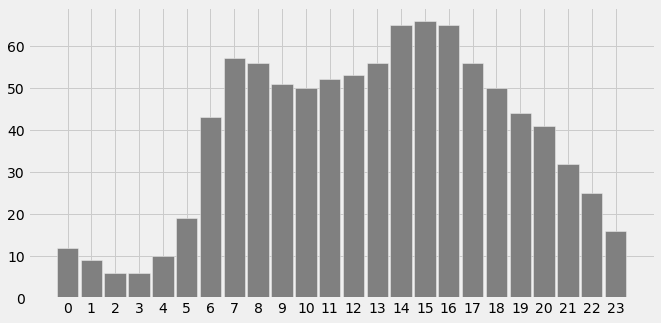

In [32]:
#Did not separate by day, assmume demande is similar for both weekdays and weekends
#Count how many days of data we have: 
grouped_demand = trips_clean.group(["origin_hr"]).sort(0 , descending = False)
demand = grouped_demand.with_column("daily demand", np.round(grouped_demand[1]/num_days)).select([0,2])
origin_hr = demand.column("origin_hr").astype(int)
daily_demand = demand.column("daily demand").astype(int)

fig= plots.figure(figsize=(10,5))
plots.bar(origin_hr, daily_demand, color = 'grey', width = 0.9, )
_ = plots.xticks(origin_hr)



We now have the demand per hour for the cars. From this we can see that the most popular hours are 6,7,8 - 17,18, which makes sense as it is when people are likely on their way to work or come back from work. We notice that 14-16h is also popular which is interesting. Maybe people use Car2Go to go for lunch in the middle of the day.

In [33]:
demand_by_zip_1 = trips_clean.group(["ozip","origin_hr"]).sort(0 , descending = False)
demand_by_zip = demand_by_zip_1.with_column("Hourly Demand", np.round(demand_by_zip_1[2]/num_days)).select([0,1,3])
demand_by_zip.show()

ozip,origin_hr,Hourly Demand
91910,0,0
91910,1,0
91910,2,0
91910,3,0
91910,4,0
91910,5,0
91910,6,0
91910,7,0
91910,8,0
91910,9,0


In [34]:
demand_by_zip_OD = trips_clean.group(["ozip","dzip","origin_hr"]).sort(0 , descending = False)
demand_by_zip_OD

ozip,dzip,origin_hr,count
91910,91910,1,4
91910,91910,2,3
91910,91910,3,1
91910,91910,4,2
91910,91910,5,1
91910,91910,6,2
91910,91910,7,1
91910,91910,8,8
91910,91910,9,8
91910,91910,10,10


In [35]:
demand_by_zip_hourly_OD = demand_by_zip_OD.with_column("Hourly Demand", np.round(demand_by_zip_OD[3]/num_days)).select([0,1,2,4])
demand_by_zip_hourly_OD.show()



ozip,dzip,origin_hr,Hourly Demand
91910,91910,1,0
91910,91910,2,0
91910,91910,3,0
91910,91910,4,0
91910,91910,5,0
91910,91910,6,0
91910,91910,7,0
91910,91910,8,0
91910,91910,9,0
91910,91910,10,0


In [36]:
zips_demand_OD = demand_by_zip_hourly_OD.pivot("ozip",make_array("dzip", "origin_hr"), values = "Hourly Demand", collect = np.sum)
zips_demand_OD.show()



dzip,origin_hr,91910,91911,92101,92102,92103,92104,92105,92106,92107,92108,92109,92110,92111,92113,92115,92116,92120,92123
91910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
91910,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Revenue Estimations

Let's use the data we have to estimate the revenue we have on average per trip.
From the internet we saw that car2go's proces oscilate between 35 and 45 cents. We are going to assume this depends on peak hour. 

We will put the higher tariffs at 7-8-9am/5-6-7pm (when people go and come back from work)  as well as during the night: 10pm to 6 am. This matches the moments of high demand

In [37]:
#Let's Create an hourly price table
prices = Table().with_columns( "Hour", np.arange(0,24)
                                 , "Price", make_array(0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.45,0.35,0.35,0.35
                                                       ,0.35,0.45,0.45,0.45,0.45,0.45,0.45,0.35,0.35,0.45,0.45))
prices.show()

Hour,Price
0,0.45
1,0.45
2,0.45
3,0.45
4,0.45
5,0.45
6,0.45
7,0.45
8,0.45
9,0.45


In [38]:
trips_clean

car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,origin_hr,dest_hr,travel.times
6NE H639,92102,92102,"C St 2258, 92102 San Diego",-117.143,32.7168,"C St 2258, 92102 San Diego",-117.143,32.7168,2014-03-27 5:55,2014-03-27 6:35,13,6,40.1341
6NE H639,92116,92116,"Park Blvd 4628, 92116 San Diego",-117.146,32.7615,"Park Blvd 4626, 92116 San Diego",-117.146,32.7615,2014-03-11 7:10,2014-03-11 7:46,15,7,35.1144
6NE H639,92110,92110,"Barnett Ave 2946, 92110 San Diego",-117.209,32.743,"Cadiz St 2719, 92110 San Diego",-117.21,32.7436,2014-03-17 0:12,2014-03-17 0:23,8,0,10.0618
6NE H639,92101,92101,"W G St 146, 92101 San Diego",-117.164,32.7125,Broadway Cir at Horton Plaza,-117.163,32.7149,2014-03-25 22:18,2014-03-25 22:48,6,22,30.1165
6NE H639,92106,92106,"Laning Rd 2601, 92106 San Diego",-117.219,32.7278,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,2014-03-21 8:42,2014-03-21 8:57,16,8,15.0504
6NE H639,92103,92103,"4th Ave 4100, 92103 San Diego",-117.161,32.7517,"W Washington St 954, 92103 San Diego",-117.172,32.7499,2014-03-28 0:54,2014-03-28 1:04,8,1,10.0348
6NE H639,92106,92106,"Decatur Rd 2216, 92106 San Diego",-117.218,32.7332,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,2014-03-24 13:15,2014-03-24 13:35,21,13,20.0851
6NE H639,92101,92103,"W Palm St 1428, 92101 San Diego",-117.175,32.733,"Reynard Way 2849, 92103 San Diego",-117.169,32.7349,2014-03-13 3:01,2014-03-13 3:11,11,3,10.0456
6NE H639,92101,92107,Broadway Cir at Horton Plaza,-117.163,32.7149,"Long Branch Ave 4891, 92107 San Diego",-117.246,32.7496,2014-03-25 23:23,2014-03-25 23:48,7,23,25.0839
6NE H639,92104,92101,"30th St 2428, 92104 San Diego",-117.13,32.7311,"Spanish Lndg, 92101 San Diego",-117.205,32.7289,2014-03-13 20:55,2014-03-13 21:30,4,21,35.1636


In [39]:
#Let's now calculate on average how much a trip bring in in terms of revenue
#First let us join the prices to the dataset we have
trips_prices = trips_clean.join("origin_hr", prices, "Hour")
trips_prices

origin_hr,car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,dest_hr,travel.times,Price
0,6NE H639,92101,92101,"16th St 138, 92101 San Diego",-117.15,32.7067,"7th Ave 1010, 92101 San Diego",-117.158,32.7159,2014-03-12 16:03,2014-03-12 16:18,16,15.0617,0.45
0,6NE H640,92103,92104,"Park Blvd 3656, 92103 San Diego",-117.148,32.7445,"Lincoln Ave 2878, 92104 San Diego",-117.132,32.7504,2014-03-11 16:23,2014-03-11 16:38,16,15.0674,0.45
0,6NE H640,92106,92106,"Plumosa Dr 3635, 92106 San Diego",-117.222,32.745,"Decatur Rd 2760, 92106 San Diego",-117.212,32.7391,2014-03-22 16:40,2014-03-22 17:10,17,30.1227,0.45
0,6NE H642,92116,92103,"Meade Ave 2422, 92116 San Diego",-117.139,32.7573,"Albatross St 4012, 92103 San Diego",-117.166,32.7502,2014-03-07 16:56,2014-03-07 17:11,17,15.0623,0.45
0,6NE H644,92101,92101,"8th Ave 1338, 92101 San Diego",-117.157,32.7193,"India St 2119, 92101 San Diego",-117.169,32.7266,2014-03-18 16:58,2014-03-18 17:13,17,15.0767,0.45
0,6NE H644,92108,92107,"Camino de la Reina 1496, 92108 San Diego",-117.149,32.7704,"Lotus St 4865, 92107 San Diego",-117.244,32.7512,2014-03-07 16:00,2014-03-07 16:20,16,20.0825,0.45
0,6NE H644,92104,92101,"31st St 3840, 92104 San Diego",-117.127,32.7479,"5th Ave 2421, 92101 San Diego",-117.16,32.7306,2014-03-22 16:40,2014-03-22 17:00,17,20.0818,0.45
0,6NE H646,92104,92104,"30th St 4084, 92104 San Diego",-117.13,32.7519,"Alabama St 4242, 92104 San Diego",-117.143,32.7546,2014-03-16 16:45,2014-03-16 16:55,16,10.0418,0.45
0,6NE H646,92106,92107,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,"Cable St 1808, 92107 San Diego",-117.251,32.7443,2014-03-10 16:47,2014-03-10 17:02,17,15.0629,0.45
0,6NE H647,92116,92116,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,2014-03-19 16:38,2014-03-19 17:03,17,25.1143,0.45


In [40]:
# Now let's calculate the revenue for each trip by multiplying the price by the travel time
trips_revenue = trips_prices.with_column("Revenue", trips_prices.column("Price")*trips_prices.column("travel.times"))
trips_revenue

origin_hr,car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,dest_hr,travel.times,Price,Revenue
0,6NE H639,92101,92101,"16th St 138, 92101 San Diego",-117.15,32.7067,"7th Ave 1010, 92101 San Diego",-117.158,32.7159,2014-03-12 16:03,2014-03-12 16:18,16,15.0617,0.45,6.77774
0,6NE H640,92103,92104,"Park Blvd 3656, 92103 San Diego",-117.148,32.7445,"Lincoln Ave 2878, 92104 San Diego",-117.132,32.7504,2014-03-11 16:23,2014-03-11 16:38,16,15.0674,0.45,6.78032
0,6NE H640,92106,92106,"Plumosa Dr 3635, 92106 San Diego",-117.222,32.745,"Decatur Rd 2760, 92106 San Diego",-117.212,32.7391,2014-03-22 16:40,2014-03-22 17:10,17,30.1227,0.45,13.5552
0,6NE H642,92116,92103,"Meade Ave 2422, 92116 San Diego",-117.139,32.7573,"Albatross St 4012, 92103 San Diego",-117.166,32.7502,2014-03-07 16:56,2014-03-07 17:11,17,15.0623,0.45,6.77802
0,6NE H644,92101,92101,"8th Ave 1338, 92101 San Diego",-117.157,32.7193,"India St 2119, 92101 San Diego",-117.169,32.7266,2014-03-18 16:58,2014-03-18 17:13,17,15.0767,0.45,6.78452
0,6NE H644,92108,92107,"Camino de la Reina 1496, 92108 San Diego",-117.149,32.7704,"Lotus St 4865, 92107 San Diego",-117.244,32.7512,2014-03-07 16:00,2014-03-07 16:20,16,20.0825,0.45,9.03712
0,6NE H644,92104,92101,"31st St 3840, 92104 San Diego",-117.127,32.7479,"5th Ave 2421, 92101 San Diego",-117.16,32.7306,2014-03-22 16:40,2014-03-22 17:00,17,20.0818,0.45,9.03679
0,6NE H646,92104,92104,"30th St 4084, 92104 San Diego",-117.13,32.7519,"Alabama St 4242, 92104 San Diego",-117.143,32.7546,2014-03-16 16:45,2014-03-16 16:55,16,10.0418,0.45,4.5188
0,6NE H646,92106,92107,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,"Cable St 1808, 92107 San Diego",-117.251,32.7443,2014-03-10 16:47,2014-03-10 17:02,17,15.0629,0.45,6.77831
0,6NE H647,92116,92116,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,2014-03-19 16:38,2014-03-19 17:03,17,25.1143,0.45,11.3014


In [41]:
#Determine the average revenue
avg_trip_revenue = round(sum(trips_revenue.column("Revenue"))/trips_revenue.num_rows, 2)
avg_trip_revenue

11.67

The average revenue made by car2go on a trip is 11.67$

## Cost Estimations

In [42]:
#Let's Create an hourly cost table
costs = Table().with_columns( "Hour", np.arange(0,24)
                                 , "Cost Per Minute", np.full((1,24), 0.18)[0])
costs.show()

Hour,Cost Per Minute
0,0.18
1,0.18
2,0.18
3,0.18
4,0.18
5,0.18
6,0.18
7,0.18
8,0.18
9,0.18


In [43]:
#Let's now calculate on average how much a trip costs
#First let us join the cost to the dataset we have
trips_costs = trips_clean.join("origin_hr", costs, "Hour")
trips_costs

origin_hr,car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,dest_hr,travel.times,Cost Per Minute
0,6NE H639,92101,92101,"16th St 138, 92101 San Diego",-117.15,32.7067,"7th Ave 1010, 92101 San Diego",-117.158,32.7159,2014-03-12 16:03,2014-03-12 16:18,16,15.0617,0.18
0,6NE H640,92103,92104,"Park Blvd 3656, 92103 San Diego",-117.148,32.7445,"Lincoln Ave 2878, 92104 San Diego",-117.132,32.7504,2014-03-11 16:23,2014-03-11 16:38,16,15.0674,0.18
0,6NE H640,92106,92106,"Plumosa Dr 3635, 92106 San Diego",-117.222,32.745,"Decatur Rd 2760, 92106 San Diego",-117.212,32.7391,2014-03-22 16:40,2014-03-22 17:10,17,30.1227,0.18
0,6NE H642,92116,92103,"Meade Ave 2422, 92116 San Diego",-117.139,32.7573,"Albatross St 4012, 92103 San Diego",-117.166,32.7502,2014-03-07 16:56,2014-03-07 17:11,17,15.0623,0.18
0,6NE H644,92101,92101,"8th Ave 1338, 92101 San Diego",-117.157,32.7193,"India St 2119, 92101 San Diego",-117.169,32.7266,2014-03-18 16:58,2014-03-18 17:13,17,15.0767,0.18
0,6NE H644,92108,92107,"Camino de la Reina 1496, 92108 San Diego",-117.149,32.7704,"Lotus St 4865, 92107 San Diego",-117.244,32.7512,2014-03-07 16:00,2014-03-07 16:20,16,20.0825,0.18
0,6NE H644,92104,92101,"31st St 3840, 92104 San Diego",-117.127,32.7479,"5th Ave 2421, 92101 San Diego",-117.16,32.7306,2014-03-22 16:40,2014-03-22 17:00,17,20.0818,0.18
0,6NE H646,92104,92104,"30th St 4084, 92104 San Diego",-117.13,32.7519,"Alabama St 4242, 92104 San Diego",-117.143,32.7546,2014-03-16 16:45,2014-03-16 16:55,16,10.0418,0.18
0,6NE H646,92106,92107,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,"Cable St 1808, 92107 San Diego",-117.251,32.7443,2014-03-10 16:47,2014-03-10 17:02,17,15.0629,0.18
0,6NE H647,92116,92116,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,2014-03-19 16:38,2014-03-19 17:03,17,25.1143,0.18


In [44]:
# Now let's calculate the cost for each trip by multiplying the cost by the travel time
trips_costs = trips_costs.with_column("Trip_Costs", trips_costs.column("Cost Per Minute")*trips_costs.column("travel.times"))
trips_costs

origin_hr,car,ozip,dzip,origin_address,origin_longitude,origin_latitude,destination_address,destination_longitude,destination_latitude,origin_time,destination_time,dest_hr,travel.times,Cost Per Minute,Trip_Costs
0,6NE H639,92101,92101,"16th St 138, 92101 San Diego",-117.15,32.7067,"7th Ave 1010, 92101 San Diego",-117.158,32.7159,2014-03-12 16:03,2014-03-12 16:18,16,15.0617,0.18,2.7111
0,6NE H640,92103,92104,"Park Blvd 3656, 92103 San Diego",-117.148,32.7445,"Lincoln Ave 2878, 92104 San Diego",-117.132,32.7504,2014-03-11 16:23,2014-03-11 16:38,16,15.0674,0.18,2.71213
0,6NE H640,92106,92106,"Plumosa Dr 3635, 92106 San Diego",-117.222,32.745,"Decatur Rd 2760, 92106 San Diego",-117.212,32.7391,2014-03-22 16:40,2014-03-22 17:10,17,30.1227,0.18,5.42208
0,6NE H642,92116,92103,"Meade Ave 2422, 92116 San Diego",-117.139,32.7573,"Albatross St 4012, 92103 San Diego",-117.166,32.7502,2014-03-07 16:56,2014-03-07 17:11,17,15.0623,0.18,2.71121
0,6NE H644,92101,92101,"8th Ave 1338, 92101 San Diego",-117.157,32.7193,"India St 2119, 92101 San Diego",-117.169,32.7266,2014-03-18 16:58,2014-03-18 17:13,17,15.0767,0.18,2.71381
0,6NE H644,92108,92107,"Camino de la Reina 1496, 92108 San Diego",-117.149,32.7704,"Lotus St 4865, 92107 San Diego",-117.244,32.7512,2014-03-07 16:00,2014-03-07 16:20,16,20.0825,0.18,3.61485
0,6NE H644,92104,92101,"31st St 3840, 92104 San Diego",-117.127,32.7479,"5th Ave 2421, 92101 San Diego",-117.16,32.7306,2014-03-22 16:40,2014-03-22 17:00,17,20.0818,0.18,3.61472
0,6NE H646,92104,92104,"30th St 4084, 92104 San Diego",-117.13,32.7519,"Alabama St 4242, 92104 San Diego",-117.143,32.7546,2014-03-16 16:45,2014-03-16 16:55,16,10.0418,0.18,1.80752
0,6NE H646,92106,92107,"Roosevelt Rd, 92106 San Diego",-117.216,32.7382,"Cable St 1808, 92107 San Diego",-117.251,32.7443,2014-03-10 16:47,2014-03-10 17:02,17,15.0629,0.18,2.71133
0,6NE H647,92116,92116,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,"Adams Ave 3034, 92116 San Diego",-117.129,32.763,2014-03-19 16:38,2014-03-19 17:03,17,25.1143,0.18,4.52057


In [45]:
#Determine the average cost
avg_trip_cost = round(sum(trips_costs.column("Trip_Costs"))/trips_costs.num_rows, 2)
avg_trip_cost

5.0

# 3. Linear Program Models


## Sets

In [46]:
zips = demand_by_zip_hourly_OD.group(["ozip"])[0] #Set of zip codes
times = np.arange(24) #Set of times

## Parameters calculated from the given data set

In [47]:
price_per_minute_high = 0.45
price_per_minute_low = 0.35

hourly_salary = 10.8
minute_salary = hourly_salary/60
customer_satisfaction_level = 0.8
cars_available = 400

We will now adjust our cost and prices based on the distances of 2 zip codes. First lets start with the mean travel time between 2 zips. Recall the table made above:

In [48]:
travel_times = trips_clean.group([1,2], np.mean).sort(2 , descending = True).select([0,1,13]).relabeled("travel.times mean", "time")
travel_times

ozip,dzip,time
92123,92123,35.1202
92123,92103,35.1249
92123,92101,20.0658
92120,92120,18.8133
92120,92116,37.6582
92120,92115,37.6404
92120,92110,47.6633
92120,92109,37.635
92120,92108,50.2011
92120,92107,32.6241


In [49]:
#Let's Create a dictionary with this information
TT = {} #Travel Times

ozip = travel_times.column(0)
dzip = travel_times.column(1)
tt = travel_times.column(2)

for i in np.arange(travel_times.num_rows):
    TT[(ozip[i],dzip[i])] = tt[i]
    
# We now have the travel times for each zip distance

In [50]:
# From this let's calculate the revenue we make per trip. 
# We will assume the averge of 35 and 45c and set a price per minute of 40c
# We will use Try and catc error in case 2 zips are not connected and set their time to 0

Price = {}

for i in zips:
    for j in zips:
        for t in times:
            if t == 10 or t == 11 or t == 12 or t == 13 or t == 20 or t == 21:
                try:
                    Price[(i,j,t)] = price_per_minute_low * TT[(i,j)]
                except KeyError:
                    Price[(i,j,t)] = 11.67 #Avg price if not found
            else:
                try:
                    Price[(i,j,t)] = price_per_minute_high * TT[(i,j)]
                except KeyError:
                    Price[(i,j,t)] = 11.67 #Avg price if not found

In [51]:
#Let's do the same thing with costs between 2 zip codes now

Costs = {}

for i in zips:
    for j in zips:
        try:
            Costs[(i,j)] = minute_salary * TT[(i,j)]
        except KeyError:
            Costs[(i,j)] = 5 #Avg price if not found


In [52]:
#Finally, let's create a Demand Dictionnary

demand = {}

ozip = demand_by_zip_hourly_OD.column(0)
dzip = demand_by_zip_hourly_OD.column(1)
hours = demand_by_zip_hourly_OD.column(2)
count = demand_by_zip_hourly_OD.column(3)

for row in np.arange(demand_by_zip_hourly_OD.num_rows):
    demand[ozip[row], dzip[row], hours[row]] = count[row]

## Linear Program - Model 1 

In [53]:
#Parameters

X = {} #number of EV trips from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
R = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
W = {} #number of EVs available at zipcode  𝑖∈𝑍  at time  𝑡∈𝑇  (current inventory of EVs)

model = Model('Car2go')

#Set the lower limits to 0 and all the variables to integers
for t in times:
    for i in zips:
        W[i,t] = model.addVar(lb = 0, vtype = GRB.INTEGER)            
        for j in zips:
                X[i,j,t] = model.addVar(lb = 0, vtype = GRB.INTEGER)
                R[i,j,t] = model.addVar(lb = 0, vtype = GRB.INTEGER)

                
#Empty Dictionnaries
con_inventory = {}                                            
con_minimum_satifaction = {}
con_maximum_needed = {}
con_supply = {}

#Constraints

for t in times:
    
    for i in zips:

        #Inventory Constraint
        
        #To make sure it is a loop, set aside hour 0 and manually set it up to come from hour 23
        
        if t == 0:
            con_inventory[i,0] = model.addConstr(W[i,0] == W[i,23] #Previous Period
                                                           - quicksum(X[i,j,0] for j in zips) #Cars that left
                                                           + quicksum(X[j,i,0] for j in zips) #Cars that arrived
                                                           - quicksum(R[i,j,0] for j in zips) #Cars repositioned away
                                                           + quicksum(R[j,i,0] for j in zips) #Cars brought back
                                                )
        else:
            
            con_inventory[i,t] = model.addConstr(W[i,t] == W[i,t-1] #Previous Period
                                                           - quicksum(X[i,j,t] for j in zips) #Cars that left
                                                           + quicksum(X[j,i,t] for j in zips) #Cars that arrived
                                                           - quicksum(R[i,j,t] for j in zips) #Cars repositioned away
                                                           + quicksum(R[j,i,t] for j in zips) #Cars brought back
                                                )
       
        for j in zips:
            
            #Customer Satisfaction Constraints
            
            try:
                con_minimum_satifaction[i,j,t] = model.addConstr(X[i,j,t] >= int(np.ceil(demand[i,j,t]*customer_satisfaction_level)))
            
            except KeyError:
                con_minimum_satifaction[i,j,t] = model.addConstr(X[i,j,t] == 0)
                                                                 
            try:
                con_maximum_needed[i,j,t] = model.addConstr(X[i,j,t] <= int(demand[i,j,t]))
            
            except KeyError:
                con_maximum_needed[i,j,t] = model.addConstr(X[i,j,t] == 0)                                                  

total_cars = model.addConstr(quicksum(W[i,0] for i in zips) <= cars_available)                                                 
                                                                 

Academic license - for non-commercial use only


In [54]:
#objective function
obj = ( quicksum(X[i,j,t]*Price[i,j,t] for i in zips for j in zips for t in times)
      - quicksum(R[i,j,t]*Costs[i,j] for i in zips for j in zips for t in times))


## Optimal Solution

In [55]:
model.setObjective(obj, GRB.MAXIMIZE)
model.optimize()

Optimize a model with 15985 rows, 15984 columns and 45810 nonzeros
Variable types: 0 continuous, 15984 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 15552 rows and 8207 columns
Presolve time: 0.03s
Presolved: 433 rows, 7777 columns, 15572 nonzeros
Variable types: 0 continuous, 7777 integer (0 binary)

Root relaxation: objective 7.722435e+03, 283 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    7722.4354265 7722.43543  0.00%     -    0s

Explored 0 nodes (283 simplex iterations) in 0.07 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 7722.44 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.722435426472e+03, best bound 7.722435426472e+03, gap 0

In [56]:
round(model.objVal,2)

7722.44

In [57]:
#Analyze Dictionnary X - Trips Taken

Trip_Start = []
Trip_Dest = []
Trip_Time = []
Trip_Amount = []

for i in zips:
    for j in zips:
        for t in times:
            if X[i,j,t].x > 0:
                Trip_Start.append(i)
                Trip_Dest.append(j)
                Trip_Time.append(t)
                Trip_Amount.append(X[i,j,t].X)

#X - Trips Taken
Number_of_Trips = Table().with_columns('Trip From', Trip_Start,
                                 'Trip To', Trip_Dest,
                                 'At Hour', Trip_Time,
                                 'Amount of Trips', Trip_Amount)
Number_of_Trips.pivot('Trip To', make_array ('Trip From','At Hour'), values = "Amount of Trips", collect = np.sum).show()


Trip From,At Hour,91911,92101,92102,92103,92104,92106,92107,92108,92109,92110,92115,92116
92101,0,0,1,0,1,0,0,0,0,0,0,0,0
92101,1,0,1,1,0,0,0,0,0,0,0,0,1
92101,3,0,1,0,0,0,0,0,0,0,0,0,0
92101,4,0,1,0,1,0,0,0,0,0,0,0,0
92101,5,0,2,0,1,0,0,0,0,0,0,0,0
92101,6,0,5,0,1,0,0,0,0,0,1,0,0
92101,7,1,11,0,2,0,0,0,1,1,0,0,0
92101,8,0,11,1,3,1,0,0,1,1,0,0,0
92101,9,0,10,1,2,0,0,0,1,1,0,0,0
92101,10,0,11,1,3,1,1,0,1,1,1,0,0


Text(0, 0.5, 'Hour T')

<Figure size 432x288 with 0 Axes>

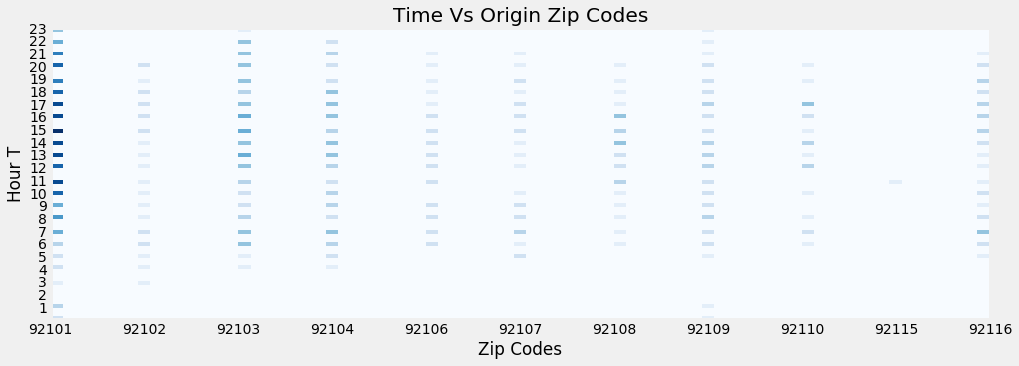

In [58]:
plots.set_cmap(cmap = 'Blues')

Number_From = []
for i in Trip_Start:
        if i == 92101:
            Number_From.append(1)
        elif i == 92102:
            Number_From.append(2)
        elif i == 92103:
            Number_From.append(3)
        elif i == 92104:
            Number_From.append(4)
        elif i == 92106:
            Number_From.append(5)
        elif i == 92107:
            Number_From.append(6)
        elif i == 92108:
            Number_From.append(7)
        elif i == 92109:
            Number_From.append(8)
        elif i == 92110:
            Number_From.append(9)
        elif i == 92115:
            Number_From.append(10)
        elif i == 92116:
            Number_From.append(11)
Number_of_Trips2 = Number_of_Trips.with_columns('Number',Number_From)
fig= plots.figure(figsize=(15,5))
plots.hist2d(Number_of_Trips2.column('Number'),Number_of_Trips2.column('At Hour'), bins = [75,75])
plots.xticks(np.arange(1,12), ['92101','92102','92103','92104','92106','92107','92108','92109','92110','92115','92116'])
plots.yticks(np.arange(1,24))
plots.title('Time Vs Origin Zip Codes')
plots.xlabel('Zip Codes')
plots.ylabel('Hour T')

Text(0, 0.5, 'Hour T')

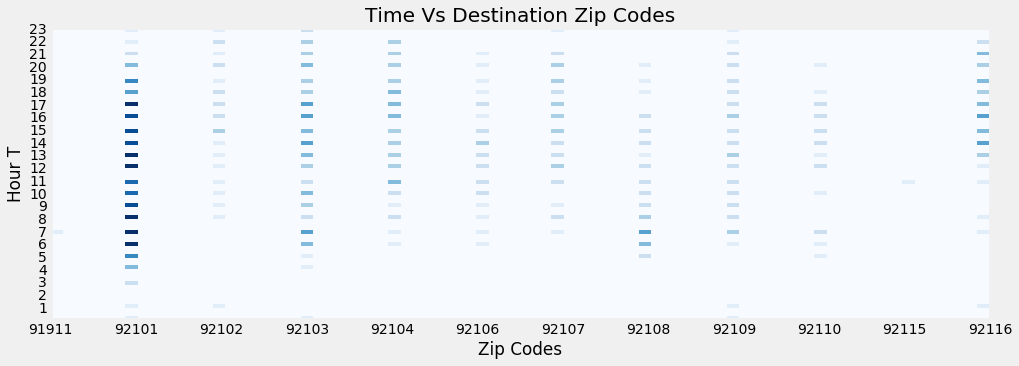

In [59]:

Number_To= []
for i in Trip_Dest:
        if i == 91911:
            Number_To.append(1)
        elif i == 92101:
            Number_To.append(2)
        elif i == 92102:
            Number_To.append(3)
        elif i == 92103:
            Number_To.append(4)
        elif i == 92104:
            Number_To.append(5)
        elif i == 92106:
            Number_To.append(6)
        elif i == 92107:
            Number_To.append(7)
        elif i == 92108:
            Number_To.append(8)
        elif i == 92109:
            Number_To.append(9)
        elif i == 92110:
            Number_To.append(10)
        elif i == 92115:
            Number_To.append(11)
        elif i == 92116:
            Number_To.append(12)
            
Number_of_Trips3 = Number_of_Trips.with_columns('Number',Number_To)
fig= plots.figure(figsize=(15,5))
plots.hist2d(Number_of_Trips3.column('Number'),Number_of_Trips3.column('At Hour'), bins = [75,75])
plots.xticks(np.arange(1,13), ['91911','92101','92102','92103','92104','92106','92107','92108','92109','92110','92115','92116'])
plots.yticks(np.arange(1,24))
plots.title('Time Vs Destination Zip Codes')
plots.xlabel('Zip Codes')
plots.ylabel('Hour T')

A high volumne of trips appear to be round trips from zipcodes: 92101 & 92103 (highly consistent with our demand count per zipcode). In terms of non-round trips, zipcode: 92101 is the most popular destination corresponding to the center of the city of San Diego (a highly popular location for tourists and locals). Although non-round trips are presented, the data suggests that round trips will be much more lucrative. 

In [60]:
#Analyze Dictionnary W - Cars available at each station
Cars_Available_Zip = []
Time = []
Amounts_Cars = []

for i in zips:
        for t in times:
            if W[i,t].x > 0:
                Cars_Available_Zip.append(i)
                Time.append(t)
                Amounts_Cars.append(W[i,t].X)

#W - Cars available at each station

Available_Cars = Table().with_columns('Location', Cars_Available_Zip,
                                 'Time', Time,
                                 'Available Cars', Amounts_Cars)
Available_Cars.pivot("Time", "Location", values = "Available Cars", collect = np.sum).show()

Location,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
91911,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92101,2,0,0,1,3,8,22,35,41,45,44,42,43,43,40,36,28,27,23,21,16,10,6,3
92102,10,11,11,10,9,8,4,0,0,0,0,0,0,1,2,3,5,6,5,6,6,7,9,10
92103,7,7,7,7,7,6,4,2,0,0,2,1,0,0,2,2,4,5,6,5,6,6,5,6
92104,15,15,15,15,14,12,8,4,3,1,0,2,2,1,1,2,4,11,12,13,14,14,15,15
92106,3,3,3,4,4,4,3,2,1,0,2,2,2,2,3,3,2,3,3,3,3,3,3,3
92107,8,8,8,7,7,5,4,2,2,1,0,1,2,0,0,0,1,2,3,4,6,7,7,8
92108,0,0,0,0,0,2,3,4,6,7,8,7,7,6,4,3,1,0,0,0,0,0,0,0
92109,2,2,2,2,2,1,0,1,0,0,0,0,0,1,0,0,2,1,1,1,1,2,2,2
92110,0,0,0,0,0,1,1,1,0,0,0,1,0,1,0,2,2,0,1,0,0,0,0,0


There appears to be many cars available at location: 92101, during the morning (Midnight - 6am). This suggests that it is one of the locations with the most active Car2Go users. Along with zipcodes: 92102, 92107, 92116, a high number of electric vehicles (double digits) are to be made available in these popular stations to satisfy their respective demand. When compared with our original analysis regarding the demand of trips originating from specific zipcodes, our model suggests a logical allocation of EV cars where popular stations are more heavily supplied in EVs than less popular ones. 

In [61]:
#Analyze Dictionnary R - Cars repositionned

Relocation_Times = []
Relocation_From = []
Relocation_To = []
Relocation_Amount = []

for i in zips:
    for j in zips:
        for t in times:
            if R[i,j,t].x > 0:
                Relocation_From.append(i)
                Relocation_To.append(j)
                Relocation_Times.append(t)
                Relocation_Amount.append(R[i,j,t].X)
                
#R - Cars repositionned
Relocation = Table().with_columns('Relocation From', Relocation_From,
                                 'Relocation To', Relocation_To,
                                 'At Hour', Relocation_Times,
                                 'Cars Repositioned', Relocation_Amount)
Relocation.pivot('Relocation To', make_array ('Relocation From','At Hour'), values = "Cars Repositioned", collect = np.sum).show()

Relocation From,At Hour,92101,92103,92104,92106,92109,92110
91911,8,1,0,0,0,0,0
92107,3,0,0,0,1,0,0
92107,11,0,0,0,0,0,1
92107,12,0,0,0,0,1,0
92107,13,0,0,0,0,2,1
92107,14,1,0,0,0,0,0
92107,15,0,0,0,0,0,1
92108,6,0,2,0,0,0,0
92108,7,3,0,0,0,0,0
92116,13,0,1,0,0,0,0


Although not relatively significant, the Gurobi Model suggests to reposition a total of 12 cars. Observing the above table, we can see that the destination where the most amount of cars (5) are to be repositioned to is at zipcode: 92104, followed by 92103 and 92102 (2). This suggests that the repositioning of cars should be less focused on the most popular zipcode location as cars will be initially placed in this location. Instead, cars should be repositioned to areas that will be relatively less popular but still require a high number of available EVs to satisfy customer demand. 


## Linear Program - Model 2

### Extra Set

In [62]:
chargers = make_array(92101,92107,92114) #Set of charging stations

### Extra Calculated Parameter

In [63]:
#We will create a dictionary that looks at the cost to go and come back from charging stations

Costs_Charging = {}

for i in zips:
    for c in chargers:
        try:
            Costs_Charging[(i,c)] = minute_salary * TT[(i,c)]
        except KeyError:
            Costs_Charging[(i,c)] = 5
            
cost_electricity = 2.64

### Model 2 Program

In [64]:

X2 = {} #number of EV trips from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
R2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
W2 = {} #number of EVs available at zipcode  𝑖∈𝑍  at time  t∈𝑇

M2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
N2 = {} #number of EVs to reposition from charging  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
C2 = {} #number of EVs available at charging station  c∈C  at time  𝑡∈𝑇

model2 = Model('Car2go2')

for t in times:
    for i in zips:
        W2[i,t] = model2.addVar(lb = 0)            
        for j in zips:
                X2[i,j,t] = model2.addVar(lb = 0)
                R2[i,j,t] = model2.addVar(lb = 0)

                
for t in times:
    for c in chargers:
        C2[c,t] = model2.addVar(lb = 0)
        for i in zips:
            M2[i,c,t] = model2.addVar(lb = 0)
            N2[c,i,t] = model2.addVar(lb = 0)


            
con_inventory_2 = {}                                            
con_minimum_satifaction_2 = {}
con_maximum_needed_2 = {}
con_repositionning_2 = {}
con_supply_2 = {}
con_charging_vehicles_2 = {}
con_inventory_charging_2 = {}
con_released_2 = {}
con_charging_max_2 = {}


for t in times:
    
    for i in zips:

        #Inventory Constraint
        if t == 0:
               con_inventory_2[i,0] = model2.addConstr(W2[i,0] == W2[i,23] #Previous Period
                                                           - quicksum(X2[i,j,0] for j in zips) #Cars that left
                                                           + quicksum(X2[j,i,0] for j in zips) #Cars that arrived
                                                           - quicksum(R2[i,j,0] for j in zips) #Cars repositioned away
                                                           + quicksum(R2[j,i,0] for j in zips) #Cars brought back
                                                           - quicksum(M2[i,c,0] for c in chargers) #Cars going to charge
                                                           + quicksum(N2[c,i,0] for c in chargers) #Cars brought from charging
                                                )                                        
        else:
            
            con_inventory_2[i,t] = model2.addConstr(W2[i,t] == W2[i,t-1] #Previous Period
                                                           - quicksum(X2[i,j,t] for j in zips) #Cars that left
                                                           + quicksum(X2[j,i,t] for j in zips) #Cars that arrived
                                                           - quicksum(R2[i,j,t] for j in zips) #Cars repositioned away
                                                           + quicksum(R2[j,i,t] for j in zips) #Cars brought back
                                                           - quicksum(M2[i,c,t] for c in chargers) #Cars going to charge
                                                           + quicksum(N2[c,i,t] for c in chargers) #Cars brought from charging

                                                )
      
        for j in zips:
            #Customer Satisfaction Constraints
            try:
                con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] >= int(np.ceil(demand[i,j,t]*customer_satisfaction_level)))
            
            except KeyError:
                con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)
                                                                 
            try:
                con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] <= int(demand[i,j,t]))
            
            except KeyError:
                con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)                                                  

# Total Cars Constraints
total_cars_2 = model2.addConstr(quicksum(W2[i,0] for i in zips) <= cars_available - quicksum(C2[c,0] for c in chargers))                                                 

for t in times:
    
    for c in chargers:
        
        #Inventory Constraints Chargers
        if t == 0:

            con_inventory_charging_2[c,0] = model2.addConstr(C2[c,0] == C2[c,23] #Cars previously there
                                                                      + quicksum(M2[i,c,0] for i in zips) #Cars that are brought to the charging station
                                                                      - quicksum(N2[c,i,0] for i in zips) #Cars that leave the charging station
                                                     )          
                
        else:
            
            con_inventory_charging_2[c,t] = model2.addConstr(C2[c,t] == C2[c,t-1] #Cars previously there
                                                                      + quicksum(M2[i,c,t] for i in zips) #Cars that are brought to the charging station
                                                                      - quicksum(N2[c,i,t] for i in zips) #Cars that leave the charging station 
                                                            )
        #Vehicle Released from charge                                                   
        if t == 0:
            con_released_2[c,i,0] = model2.addConstr(quicksum(N2[c,i,0] for i in zips) == quicksum(M2[i,c,20] for i in zips)) 
        elif t == 1:    
            con_released_2[c,i,1] = model2.addConstr(quicksum(N2[c,i,1] for i in zips) == quicksum(M2[i,c,21] for i in zips)) 
        elif t == 2:     
            con_released_2[c,i,2] = model2.addConstr(quicksum(N2[c,i,2] for i in zips) == quicksum(M2[i,c,22] for i in zips))   
        elif t == 3:     
            con_released_2[c,i,3] = model2.addConstr(quicksum(N2[c,i,3] for i in zips) == quicksum(M2[i,c,23] for i in zips))                 
        else:     
            con_released_2[c,i,t] = model2.addConstr(quicksum(N2[c,i,t] for i in zips) == quicksum(M2[i,c,t-4] for i in zips))        

            
for t in times:
    for i in zips:
        #Vehicles going to charging    
        con_charging_vehicles_2[t] = model2.addConstr(quicksum(M2[i,c,t] for c in chargers) == 0.1*quicksum(X2[j,i,t] for j in zips))                                                       
                                                             
                                                        


In [65]:
#objective function
obj2 = ( quicksum(X2[i,j,t]*Price[i,j,t]  for i in zips for j in zips for t in times)
       - quicksum(R2[i,j,t]*Costs[i,j] for i in zips for j in zips for t in times)
       - quicksum((M2[i,c,t]*Costs_Charging[i,c] + M2[i,c,t]*cost_electricity) for i in zips for c in chargers for t in times)
       - quicksum(N2[c,i,t]*Costs_Charging[i,c] for c in chargers for i in zips for t in times)
      )

In [66]:
model2.setObjective(obj2, GRB.MAXIMIZE)
model2.optimize()

Optimize a model with 16561 rows, 18648 columns and 62805 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15825 rows and 9032 columns
Presolve time: 0.04s
Presolved: 736 rows, 9616 columns, 21411 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.467e+03
 Factor NZ  : 3.310e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.68584443e+06  4.94317324e+03  1.69e+03 1.10e+01  4.01e+03     0s
   1  -2.44969397e+06  8.83609206e+04  1.21e+03 6.22e-14  7.46e+02     0s
   2  -1.64996361e+04  4.94029839e+04  1.03e+01 5.68e-14  1.09e+01     0s
   3   5.01889499e+03  1.73160200

In [67]:
round(model2.objVal,2)

6960.82

### Results

In [68]:
Trip_Start2 = []
Trip_Dest2 = []
Trip_Time2 = []
Trip_Amount2 = []

for i in zips:
    for j in zips:
        for t in times:
            if X2[i,j,t].x > 0:
                Trip_Start2.append(i)
                Trip_Dest2.append(j)
                Trip_Time2.append(t)
                Trip_Amount2.append(X2[i,j,t].X)

#X - Trips Taken
Number_of_Trips_Model2 = Table().with_columns('Trip From', Trip_Start2,
                                 'Trip To', Trip_Dest2,
                                 'At Hour', Trip_Time2,
                                 'Amount of Trips', Trip_Amount2)
Number_of_Trips_Model2.pivot('Trip To', make_array ('Trip From','At Hour'), values = "Amount of Trips", collect = np.sum).show()

Trip From,At Hour,91911,92101,92102,92103,92104,92106,92107,92108,92109,92110,92115,92116
92101,0,0,1,0,1,0,0,0,0,0,0,0,0
92101,1,0,1,1,0,0,0,0,0,0,0,0,1
92101,3,0,1,0,0,0,0,0,0,0,0,0,0
92101,4,0,1,0,1,0,0,0,0,0,0,0,0
92101,5,0,2,0,1,0,0,0,0,0,0,0,0
92101,6,0,5,0,1,0,0,0,0,0,1,0,0
92101,7,1,11,0,2,0,0,0,1,1,0,0,0
92101,8,0,11,1,3,1,0,0,1,1,0,0,0
92101,9,0,10,1,2,0,0,0,1,1,0,0,0
92101,10,0,11,1,3,1,1,0,1,1,1,0,0


Text(0, 0.5, 'Hour T')

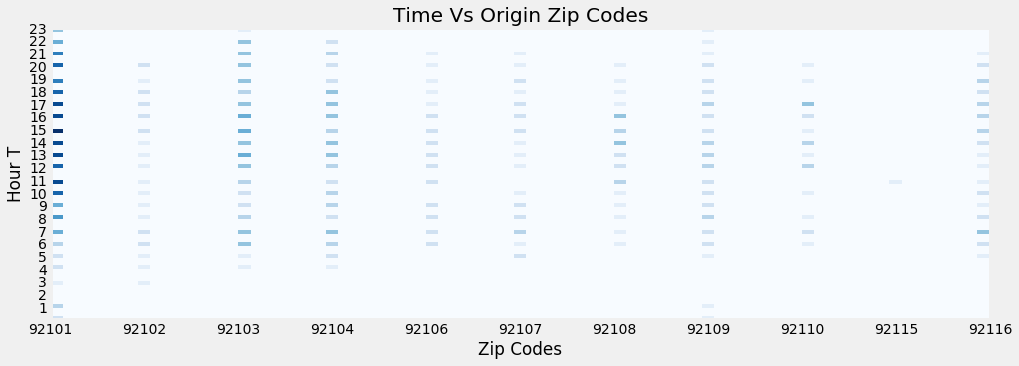

In [69]:
Trip_From = []
for i in Trip_Start2:
        if i == 92101:
            Trip_From.append(1)
        elif i == 92102:
            Trip_From.append(2)
        elif i == 92103:
            Trip_From.append(3)
        elif i == 92104:
            Trip_From.append(4)
        elif i == 92106:
            Trip_From.append(5)
        elif i == 92107:
            Trip_From.append(6)
        elif i == 92108:
            Trip_From.append(7)
        elif i == 92109:
            Trip_From.append(8)
        elif i == 92110:
            Trip_From.append(9)
        elif i == 92115:
            Trip_From.append(10)
        elif i == 92116:
            Trip_From.append(11)
            
New_Number_of_Trips_Model2 = Number_of_Trips_Model2.with_columns('Number',Trip_From)
fig= plots.figure(figsize=(15,5))
plots.hist2d(New_Number_of_Trips_Model2.column('Number'),New_Number_of_Trips_Model2.column('At Hour'), bins = [75,75])
plots.xticks(np.arange(1,12), ['92101','92102','92103','92104','92106','92107','92108','92109','92110','92115','92116'])
plots.yticks(np.arange(1,24))
plots.title('Time Vs Origin Zip Codes')
plots.xlabel('Zip Codes')
plots.ylabel('Hour T')


Text(0, 0.5, 'Hour T')

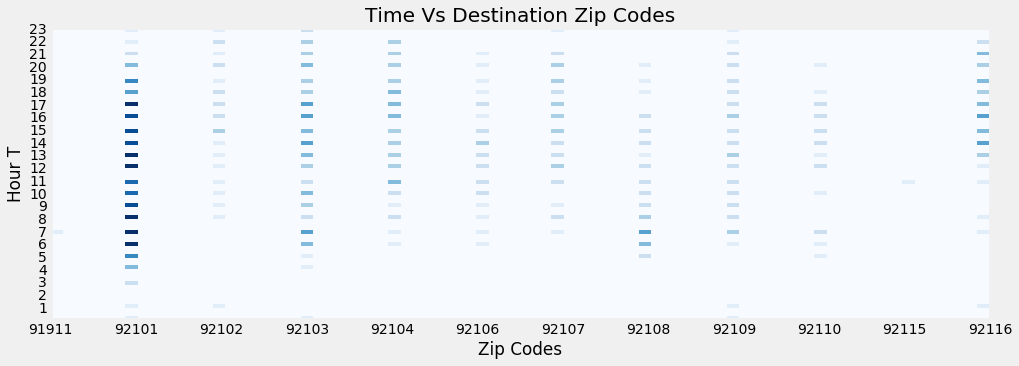

In [70]:
Trip_To = []
for i in Trip_Dest2:
        if i == 91911:
            Trip_To.append(1)
        elif i == 92101:
            Trip_To.append(2)
        elif i == 92102:
            Trip_To.append(3)
        elif i == 92103:
            Trip_To.append(4)
        elif i == 92104:
            Trip_To.append(5)
        elif i == 92106:
            Trip_To.append(6)
        elif i == 92107:
            Trip_To.append(7)
        elif i == 92108:
            Trip_To.append(8)
        elif i == 92109:
            Trip_To.append(9)
        elif i == 92110:
            Trip_To.append(10)
        elif i == 92115:
            Trip_To.append(11)
        elif i == 92116:
            Trip_To.append(12)
            
            
New2_Number_of_Trips_Model2 = Number_of_Trips_Model2.with_columns('Number',Trip_To)
fig= plots.figure(figsize=(15,5))
plots.hist2d(New2_Number_of_Trips_Model2.column('Number'),New_Number_of_Trips_Model2.column('At Hour'), bins = [75,75])
plots.xticks(np.arange(1,13), ['91911','92101','92102','92103','92104','92106','92107','92108','92109','92110','92115','92116'])
plots.yticks(np.arange(1,24))
plots.title('Time Vs Destination Zip Codes')
plots.xlabel('Zip Codes')
plots.ylabel('Hour T')

In [71]:
#Analyze Dictionnary W - Cars available at each station
Cars_Available_Zip2 = []
Time2 = []
Amounts_Cars2 = []

for i in zips:
        for t in times:
            if W2[i,t].x > 0:
                Cars_Available_Zip2.append(i)
                Time2.append(t)
                Amounts_Cars2.append(round(W2[i,t].X))

#W - Cars available at each station

Available_Cars_Model2 = Table().with_columns('Location', Cars_Available_Zip2,
                                 'Time', Time2,
                                 'Available Cars', Amounts_Cars2)
Available_Cars_Model2.pivot("Time", "Location", values = "Available Cars", collect = np.sum).show()

Location,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
91911,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
92101,2,0,0,1,2,7,18,26,29,31,28,26,28,29,26,22,15,16,14,14,12,8,6,3
92102,11,12,12,10,10,8,4,1,0,0,0,0,0,1,2,2,4,4,3,4,4,5,7,7
92103,8,8,9,10,10,9,4,2,0,0,5,4,4,2,3,2,3,3,3,2,2,2,1,5
92104,8,15,15,15,14,12,8,4,3,1,0,3,3,2,2,4,5,5,5,6,7,6,7,7
92106,4,4,4,4,4,4,3,2,1,0,2,2,2,2,2,3,2,3,4,4,3,4,4,4
92107,7,7,7,7,7,5,4,2,2,1,0,2,4,4,5,6,6,7,8,9,10,11,11,12
92108,2,0,0,0,0,2,4,8,10,10,11,10,10,9,7,5,3,2,2,2,2,2,2,2
92109,8,8,8,8,8,7,6,6,5,5,5,4,3,2,0,0,2,2,3,4,6,8,8,8
92110,4,4,4,4,4,5,5,5,4,4,4,4,3,3,2,2,2,0,1,0,1,1,1,1


In [72]:
#Repositionned cars

#Analyze Dictionnary R - Cars repositionned

Relocation_Times2 = []
Relocation_From2 = []
Relocation_To2 = []
Relocation_Amount2 = []

for i in zips:
    for j in zips:
        for t in times:
            if R2[i,j,t].X >= 1:
                Relocation_From2.append(i)
                Relocation_To2.append(j)
                Relocation_Times2.append(t)
                Relocation_Amount2.append(round(R2[i,j,t].X))
                
#R - Cars repositionned
Relocation2 = Table().with_columns('Relocation From', Relocation_From2,
                                 'Relocation To', Relocation_To2,
                                 'At Hour', Relocation_Times2,
                                 'Cars Repositioned', Relocation_Amount2)

Relocation2.pivot('Relocation To', make_array ('Relocation From','At Hour'), values = "Cars Repositioned", collect = np.sum).show()

Relocation From,At Hour,92102,92104,92110
92107,0,2,0,2
92108,1,0,2,0
92116,1,0,4,0


In [73]:
#number of EVs available at charging station  c∈C  at time  𝑡∈𝑇

Quantity = []
Hour3 =[]
Cumulative_Amount3 = []

for c in chargers:
    for t in times:
        if C2[c,t].X > 0:
            Quantity.append(c)
            Hour3.append(t)
            Cumulative_Amount3.append(round(C2[c,t].X))
                
Going_to_Charge3 = Table().with_columns('Quantity', Quantity,
                                 'At Hour', Hour3,
                                 'Cars Charging', Cumulative_Amount3)
Going_to_Charge3.pivot('At Hour', 'Quantity', values = "Cars Charging", collect = np.sum).show()

Quantity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
92101,2,1,0,0,0,1,4,7,9,11,11,10,10,10,11,12,13,13,12,10,8,6,5,3
92107,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,2,2,2,1,1,1
92114,2,1,0,0,0,0,1,2,3,3,3,3,3,4,4,5,6,6,5,5,4,4,4,3


In [74]:
#number of EVs to reposition from zipcode  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇

Coming_From = []
Going_To = []
Hour =[]
Cumulative_Amount = []

for i in zips:
    for c in chargers:
        for t in times:
            if M2[i,c,t].x > 0:
                Coming_From.append(i)
                Going_To.append(c)
                Hour.append(t)
                Cumulative_Amount.append(((np.ceil(M2[i,c,t].X))))
                
Going_to_Charge = Table().with_columns('Coming From', Coming_From,
                                 'Going To', Going_To,
                                 'At Hour', Hour,
                                 'Cars Brought', Cumulative_Amount)
Going_to_Charge.pivot('Going To', make_array ('Coming From','At Hour'), values = "Cars Brought", collect = np.sum).show()

Coming From,At Hour,92101,92107,92114
91911,7,0,0,1
92101,0,1,0,0
92101,1,1,0,0
92101,3,1,0,0
92101,4,1,0,0
92101,5,1,0,0
92101,6,3,0,0
92101,7,3,0,0
92101,8,3,0,0
92101,9,2,0,0


Text(0, 0.5, 'Hour T')

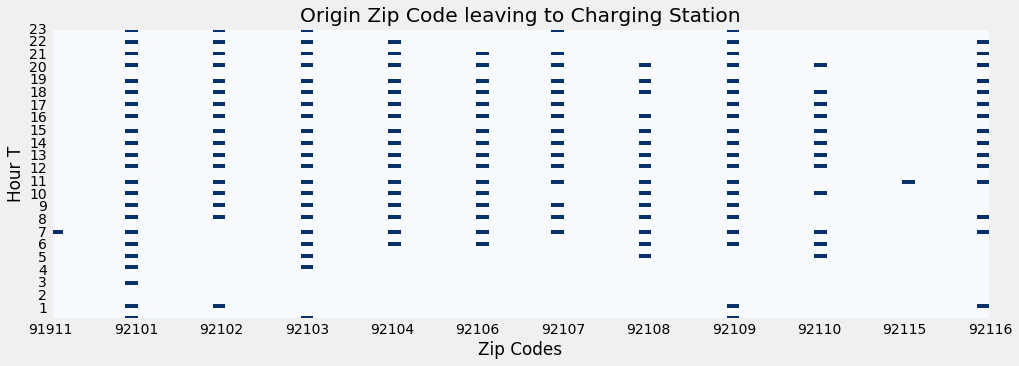

In [75]:
Charging_From = []
for i in Coming_From:
        if i == 91911:
            Charging_From.append(1)
        elif i == 92101:
            Charging_From.append(2)
        elif i == 92102:
            Charging_From.append(3)
        elif i == 92103:
            Charging_From.append(4)
        elif i == 92104:
            Charging_From.append(5)
        elif i == 92106:
            Charging_From.append(6)
        elif i == 92107:
            Charging_From.append(7)
        elif i == 92108:
            Charging_From.append(8)
        elif i == 92109:
            Charging_From.append(9)
        elif i == 92110:
            Charging_From.append(10)
        elif i == 92115:
            Charging_From.append(11)
        elif i == 92116:
            Charging_From.append(12)
            
Charging_Model2 = Going_to_Charge.with_columns('Number',Charging_From)
fig= plots.figure(figsize=(15,5))
plots.hist2d(Charging_Model2.column('Number'),Charging_Model2.column('At Hour'), bins = [75,75])
plots.xticks(np.arange(1,13), ['91911','92101','92102','92103','92104','92106','92107',
                               '92108','92109','92110','92115','92116'])
plots.yticks(np.arange(1,24))
plots.title('Origin Zip Code leaving to Charging Station')
plots.xlabel('Zip Codes')
plots.ylabel('Hour T')

This table indicates the amount of cars leaving zip codes to reach the charging stations. Therefore, the table is related to the amount of cars available at each zip code at each time. As expected, most amount of vehicles leaving are from ZipCode 92101 due to the already highly present EVs. 

In [76]:
## number of EVs to reposition from charging station  c∈C to 𝑖∈𝑍  at time  𝑡∈𝑇

Coming_From2 = []
Going_To2 = []
Hour2 =[]
Cumulative_Amount2 = []

for i in zips:
    for c in chargers:
        for t in times:
            if N2[c,i,t].x > 0:
                Coming_From2.append(c)
                Going_To2.append(i)
                Hour2.append(t)
                Cumulative_Amount2.append(np.ceil(N2[c,i,t].X))
                
Going_to_Charge2 = Table().with_columns('Coming From', Coming_From2,
                                 'Going To', Going_To2,
                                 'At Hour', Hour2,
                                 'Cars Brought', Cumulative_Amount2)

In [77]:
Charging_Model_92101 = Going_to_Charge2.where('Coming From', are.equal_to (92101))
Charging_Model_92101.pivot('Going To', make_array ('Coming From','At Hour'), values = "Cars Brought", collect = np.sum).show()

Coming From,At Hour,92101,92103
92101,0,0,2
92101,1,0,1
92101,2,0,1
92101,3,0,1
92101,4,0,1
92101,5,0,1
92101,7,0,1
92101,8,0,1
92101,9,0,1
92101,10,0,3


In [78]:
Charging_Model_92107 = Going_to_Charge2.where('Coming From', are.equal_to (92107))
Charging_Model_92107.pivot('Going To', make_array ('Coming From','At Hour'), values = "Cars Brought", collect = np.sum).show()

Coming From,At Hour,92106,92110
92107,0,0,1
92107,1,0,1
92107,3,0,1
92107,10,0,1
92107,11,0,1
92107,12,1,1
92107,13,1,0
92107,14,1,0
92107,15,1,0
92107,16,1,0


In [79]:
Charging_Model_92114 = Going_to_Charge2.where('Coming From', are.equal_to (92114))
Charging_Model_92114.pivot('Going To', make_array ('Coming From','At Hour'), values = "Cars Brought", collect = np.sum).show()

Coming From,At Hour,92103,92104,92109,92115
92114,0,0,2,0,0
92114,1,0,1,0,0
92114,2,0,1,0,0
92114,3,0,0,1,0
92114,4,1,0,0,0
92114,5,0,1,0,1
92114,9,0,1,0,0
92114,10,1,0,0,0
92114,11,0,2,0,0
92114,12,1,1,0,0


Based on each individual table, we can see that charging station 92114 distirbute EVs to the most distinct amount of ZipCodes. However, charging station 92101 distributes the largest amount of EVs due to its close proximity with locations of high demand. As expected, EVs are sent to the same zipcode as the charging station (92101) due to its high popularity and low associated cost as they are in the same location. 

# 4. Sensitivity Analysis

## Analysis 1: Loss of Cars from Flood Damage

$\quad$ Now that we have a fully functioning model, we will start with our sensitivity analysis. The first one we will look at is what happens if our cars get damaged. The reason we chose this topic is because there have been many flash flood warnings in San Diego in 2017. It is therefore important for management to take into account the number of car we will lose. EV’s may be significantly damaged rendered completely unusable after flooding occurs. We will therefore look at what happens if we cnage the number of cars available. To do so we will assume 10% of the vehicles of the city will be damaged and therefore not usable. We will also attempt to find the lowest number of cars needed in order to satisfy the demand.

In [80]:
def sensitivity_AC(cars_remainning):

    X2 = {} #number of EV trips from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
    R2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
    W2 = {} #number of EVs available at zipcode  𝑖∈𝑍  at time  t∈𝑇

    M2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
    N2 = {} #number of EVs to reposition from charging  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
    C2 = {} #number of EVs available at charging station  c∈C  at time  𝑡∈𝑇

    model2 = Model('Car2go2')

    for t in times:
        for i in zips:
            W2[i,t] = model2.addVar(lb = 0)            
            for j in zips:
                    X2[i,j,t] = model2.addVar(lb = 0)
                    R2[i,j,t] = model2.addVar(lb = 0)


    for t in times:
        for c in chargers:
            C2[c,t] = model2.addVar(lb = 0)
            for i in zips:
                M2[i,c,t] = model2.addVar(lb = 0)
                N2[c,i,t] = model2.addVar(lb = 0)



    con_inventory_2 = {}                                            
    con_minimum_satifaction_2 = {}
    con_maximum_needed_2 = {}
    con_repositionning_2 = {}
    con_supply_2 = {}
    con_charging_vehicles_2 = {}
    con_inventory_charging_2 = {}
    con_released_2 = {}
    con_charging_max_2 = {}


    for t in times:

        for i in zips:

            #Inventory Constraint
            if t == 0:
                   con_inventory_2[i,0] = model2.addConstr(W2[i,0] == W2[i,23] #Previous Period
                                                               - quicksum(X2[i,j,0] for j in zips) #Cars that left
                                                               + quicksum(X2[j,i,0] for j in zips) #Cars that arrived
                                                               - quicksum(R2[i,j,0] for j in zips) #Cars repositioned away
                                                               + quicksum(R2[j,i,0] for j in zips) #Cars brought back
                                                               - quicksum(M2[i,c,0] for c in chargers) #Cars going to charge
                                                               + quicksum(N2[c,i,0] for c in chargers) #Cars brought from charging
                                                    )                                        
            else:

                con_inventory_2[i,t] = model2.addConstr(W2[i,t] == W2[i,t-1] #Previous Period
                                                               - quicksum(X2[i,j,t] for j in zips) #Cars that left
                                                               + quicksum(X2[j,i,t] for j in zips) #Cars that arrived
                                                               - quicksum(R2[i,j,t] for j in zips) #Cars repositioned away
                                                               + quicksum(R2[j,i,t] for j in zips) #Cars brought back
                                                               - quicksum(M2[i,c,t] for c in chargers) #Cars going to charge
                                                               + quicksum(N2[c,i,t] for c in chargers) #Cars brought from charging

                                                    )

            for j in zips:
                #Customer Satisfaction Constraints
                try:
                    con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] >= int(np.ceil(demand[i,j,t]*customer_satisfaction_level)))

                except KeyError:
                    con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)

                try:
                    con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] <= int(demand[i,j,t]))

                except KeyError:
                    con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)                                                  

    # Total Cars Constraints
    total_cars_2 = model2.addConstr(quicksum(W2[i,0] for i in zips) <= cars_available*cars_remainning - quicksum(C2[c,0] for c in chargers))                                                 

    for t in times:

        for c in chargers:

            #Inventory Constraints Chargers
            if t == 0:

                con_inventory_charging_2[c,0] = model2.addConstr(C2[c,0] == C2[c,23] #Cars previously there
                                                                          + quicksum(M2[i,c,0] for i in zips) #Cars that are brought to the charging station
                                                                          - quicksum(N2[c,i,0] for i in zips) #Cars that leave the charging station
                                                         )          

            else:

                con_inventory_charging_2[c,t] = model2.addConstr(C2[c,t] == C2[c,t-1] #Cars previously there
                                                                          + quicksum(M2[i,c,t] for i in zips) #Cars that are brought to the charging station
                                                                          - quicksum(N2[c,i,t] for i in zips) #Cars that leave the charging station 
                                                                )
            #Vehicle Released from charge                                                   
            if t == 0:
                con_released_2[c,i,0] = model2.addConstr(quicksum(N2[c,i,0] for i in zips) == quicksum(M2[i,c,20] for i in zips)) 
            elif t == 1:    
                con_released_2[c,i,1] = model2.addConstr(quicksum(N2[c,i,1] for i in zips) == quicksum(M2[i,c,21] for i in zips)) 
            elif t == 2:     
                con_released_2[c,i,2] = model2.addConstr(quicksum(N2[c,i,2] for i in zips) == quicksum(M2[i,c,22] for i in zips))   
            elif t == 3:     
                con_released_2[c,i,3] = model2.addConstr(quicksum(N2[c,i,3] for i in zips) == quicksum(M2[i,c,23] for i in zips))                 
            else:     
                con_released_2[c,i,t] = model2.addConstr(quicksum(N2[c,i,t] for i in zips) == quicksum(M2[i,c,t-4] for i in zips))        


    for t in times:
        for i in zips:
            #Vehicles going to charging    
            con_charging_vehicles_2[t] = model2.addConstr(quicksum(M2[i,c,t] for c in chargers) == 0.1*quicksum(X2[j,i,t] for j in zips))                                                       
    
    #objective function
    obj2 = ( quicksum(X2[i,j,t]*Price[i,j,t]  for i in zips for j in zips for t in times)
           - quicksum(R2[i,j,t]*Costs[i,j] for i in zips for j in zips for t in times)
           - quicksum((M2[i,c,t]*Costs_Charging[i,c] + M2[i,c,t]*cost_electricity) for i in zips for c in chargers for t in times)
           - quicksum(N2[c,i,t]*Costs_Charging[i,c] for c in chargers for i in zips for t in times)
          )
                                                        
    model2.setObjective(obj2, GRB.MAXIMIZE)
    model2.optimize()
    
    return round(model2.objVal,2)




In [81]:
sensitivity_AC(0.9)

Optimize a model with 16561 rows, 18648 columns and 62805 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15825 rows and 9032 columns
Presolve time: 0.06s
Presolved: 736 rows, 9616 columns, 21411 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.467e+03
 Factor NZ  : 3.310e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.51821018e+06  4.99856425e+03  1.59e+03 1.10e+01  3.76e+03     0s
   1  -2.29901537e+06  8.67274919e+04  1.14e+03 7.11e-14  7.03e+02     0s
   2  -1.70734767e+04  4.95845144e+04  1.07e+01 7.11e-14  1.11e+01     0s
   3   4.90200863e+03  1.72671659

6960.82

No problem to lose 10% of cars

In [82]:
sensitivity_AC(0.2)

Optimize a model with 16561 rows, 18648 columns and 62805 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15825 rows and 9032 columns
Presolve time: 0.05s
Presolved: 736 rows, 9616 columns, 21411 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.467e+03
 Factor NZ  : 3.310e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.08187070e+06  5.38637851e+03  6.83e+02 1.10e+01  1.62e+03     0s
   1  -9.32107993e+05  6.63717208e+04  3.77e+02 2.06e-13  2.66e+02     0s
   2  -1.22268228e+04  4.52564043e+04  7.14e+00 1.46e-13  8.88e+00     0s
   3   4.92698239e+03  1.47498528

6960.82

Curious, you can lose 90% of your cars and still satify the constarints. This means that Car2Go has way to many cars

In [83]:
sensitivity_AC(0.14)

Optimize a model with 16561 rows, 18648 columns and 62805 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15825 rows and 9032 columns
Presolve time: 0.06s
Presolved: 736 rows, 9616 columns, 21411 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.467e+03
 Factor NZ  : 3.310e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -8.96577259e+05  5.41962802e+03  5.67e+02 1.10e+01  1.34e+03     0s
   1  -6.88595043e+05  6.06319441e+04  1.41e+02 1.39e-13  1.40e+02     0s
   2  -1.77216959e+04  3.29725834e+04  4.62e+00 1.60e-13  7.09e+00     0s
   3   4.08914549e+03  1.46576497

6955.26

Only need 14% of the cars to get the same amount of profits!!

In [84]:
sensitivity_AC(0.04)

Optimize a model with 16561 rows, 18648 columns and 62805 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15825 rows and 9032 columns
Presolve time: 0.05s
Presolved: 736 rows, 9616 columns, 21411 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.467e+03
 Factor NZ  : 3.310e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -4.69852903e+05  5.47504773e+03  2.99e+02 1.10e+01  7.05e+02     0s
   1  -3.94231529e+05  2.15140068e+04  1.33e+02 5.68e-14  9.97e+01     0s
   2  -3.69431322e+04  1.80691142e+04  1.04e+01 1.01e-13  9.97e+00     0s
   3  -1.71953673e+04  1.14885407

AttributeError: b"Unable to retrieve attribute 'objVal'"

If we have 4% of the ars we canot satisfy the demand. So we only really need 5% of them. We however reach optimal profit at 7%

## Analysis 2: Increased Wage Cost

$\quad$ In our last meeting with Mr. DeLong, asked us to investigate how a change in salary will affect his profits. He obviously knows they will go down, but he wants to understand by how much it affects profits. He is getting huge pressure from the union to increase the salaries of people who reposition cars as it is too close to minimum wage for such a tiring job. The workers are demand an hourly wage increase from 10.8$\$$ to 12 $\$$

In [85]:
def sensitivity_wage(new_wage):

    #New Parameters:
    minute_salary_new = new_wage/60
    
    #Find new Average cost per trip
    costs_new = Table().with_columns( "Hour", np.arange(0,24)
                                     , "Cost Per Minute", np.full((1,24), minute_salary_new)[0])
    #Let's now calculate on average how much a trip costs
    #First let us join the cost to the dataset we have
    trips_costs_new = trips_clean.join("origin_hr", costs_new, "Hour")

    # Now let's calculate the cost for each trip by multiplying the cost by the travel time
    trips_costs_new = trips_costs_new.with_column("Trip_Costs", trips_costs_new.column("Cost Per Minute")*trips_costs_new.column("travel.times"))

    #Determine the average cost
    avg_trip_cost = round(sum(trips_costs_new.column("Trip_Costs"))/trips_costs_new.num_rows, 2)
    
    
    # New Costs Dictionnary
    Costs_New = {}
    for i in zips:
        for j in zips:
            try:
                Costs_New[(i,j)] = minute_salary_new * TT[(i,j)]
            except KeyError:
                Costs_New[(i,j)] = avg_trip_cost #(New costs if salary goes to 12)
    
    
    # New Charging Costs Dictionnary
    Costs_Charging_New = {}

    for i in zips:
        for c in chargers:
            try:
                Costs_Charging_New[(i,c)] = minute_salary_new * TT[(i,c)]
            except KeyError:
                Costs_Charging_New[(i,c)] = avg_trip_cost
                
                
    
    X2 = {} #number of EV trips from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
    R2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
    W2 = {} #number of EVs available at zipcode  𝑖∈𝑍  at time  t∈𝑇

    M2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
    N2 = {} #number of EVs to reposition from charging  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
    C2 = {} #number of EVs available at charging station  c∈C  at time  𝑡∈𝑇

    model2 = Model('Car2go2')

    for t in times:
        for i in zips:
            W2[i,t] = model2.addVar(lb = 0)            
            for j in zips:
                    X2[i,j,t] = model2.addVar(lb = 0)
                    R2[i,j,t] = model2.addVar(lb = 0)


    for t in times:
        for c in chargers:
            C2[c,t] = model2.addVar(lb = 0)
            for i in zips:
                M2[i,c,t] = model2.addVar(lb = 0)
                N2[c,i,t] = model2.addVar(lb = 0)



    con_inventory_2 = {}                                            
    con_minimum_satifaction_2 = {}
    con_maximum_needed_2 = {}
    con_repositionning_2 = {}
    con_supply_2 = {}
    con_charging_vehicles_2 = {}
    con_inventory_charging_2 = {}
    con_released_2 = {}
    con_charging_max_2 = {}


    for t in times:

        for i in zips:

            #Inventory Constraint
            if t == 0:
                   con_inventory_2[i,0] = model2.addConstr(W2[i,0] == W2[i,23] #Previous Period
                                                               - quicksum(X2[i,j,0] for j in zips) #Cars that left
                                                               + quicksum(X2[j,i,0] for j in zips) #Cars that arrived
                                                               - quicksum(R2[i,j,0] for j in zips) #Cars repositioned away
                                                               + quicksum(R2[j,i,0] for j in zips) #Cars brought back
                                                               - quicksum(M2[i,c,0] for c in chargers) #Cars going to charge
                                                               + quicksum(N2[c,i,0] for c in chargers) #Cars brought from charging
                                                    )                                        
            else:

                con_inventory_2[i,t] = model2.addConstr(W2[i,t] == W2[i,t-1] #Previous Period
                                                               - quicksum(X2[i,j,t] for j in zips) #Cars that left
                                                               + quicksum(X2[j,i,t] for j in zips) #Cars that arrived
                                                               - quicksum(R2[i,j,t] for j in zips) #Cars repositioned away
                                                               + quicksum(R2[j,i,t] for j in zips) #Cars brought back
                                                               - quicksum(M2[i,c,t] for c in chargers) #Cars going to charge
                                                               + quicksum(N2[c,i,t] for c in chargers) #Cars brought from charging

                                                    )

            for j in zips:
                #Customer Satisfaction Constraints
                try:
                    con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] >= int(np.ceil(demand[i,j,t]*customer_satisfaction_level)))

                except KeyError:
                    con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)

                try:
                    con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] <= int(demand[i,j,t]))

                except KeyError:
                    con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)                                                  

    # Total Cars Constraints
    total_cars_2 = model2.addConstr(quicksum(W2[i,0] for i in zips) <= cars_available - quicksum(C2[c,0] for c in chargers))                                                 

    for t in times:

        for c in chargers:

            #Inventory Constraints Chargers
            if t == 0:

                con_inventory_charging_2[c,0] = model2.addConstr(C2[c,0] == C2[c,23] #Cars previously there
                                                                          + quicksum(M2[i,c,0] for i in zips) #Cars that are brought to the charging station
                                                                          - quicksum(N2[c,i,0] for i in zips) #Cars that leave the charging station
                                                         )          

            else:

                con_inventory_charging_2[c,t] = model2.addConstr(C2[c,t] == C2[c,t-1] #Cars previously there
                                                                          + quicksum(M2[i,c,t] for i in zips) #Cars that are brought to the charging station
                                                                          - quicksum(N2[c,i,t] for i in zips) #Cars that leave the charging station 
                                                                )
            #Vehicle Released from charge                                                   
            if t == 0:
                con_released_2[c,i,0] = model2.addConstr(quicksum(N2[c,i,0] for i in zips) == quicksum(M2[i,c,20] for i in zips)) 
            elif t == 1:    
                con_released_2[c,i,1] = model2.addConstr(quicksum(N2[c,i,1] for i in zips) == quicksum(M2[i,c,21] for i in zips)) 
            elif t == 2:     
                con_released_2[c,i,2] = model2.addConstr(quicksum(N2[c,i,2] for i in zips) == quicksum(M2[i,c,22] for i in zips))   
            elif t == 3:     
                con_released_2[c,i,3] = model2.addConstr(quicksum(N2[c,i,3] for i in zips) == quicksum(M2[i,c,23] for i in zips))                 
            else:     
                con_released_2[c,i,t] = model2.addConstr(quicksum(N2[c,i,t] for i in zips) == quicksum(M2[i,c,t-4] for i in zips))        


    for t in times:
        for i in zips:
            #Vehicles going to charging    
            con_charging_vehicles_2[t] = model2.addConstr(quicksum(M2[i,c,t] for c in chargers) == 0.1*quicksum(X2[j,i,t] for j in zips))                                                       
    
    #objective function
    obj2 = ( quicksum(X2[i,j,t]*Price[i,j,t]  for i in zips for j in zips for t in times)
           - quicksum(R2[i,j,t]*Costs_New[i,j] for i in zips for j in zips for t in times)
           - quicksum((M2[i,c,t]*Costs_Charging[i,c] + M2[i,c,t]*cost_electricity) for i in zips for c in chargers for t in times)
           - quicksum(N2[c,i,t]*Costs_Charging_New[i,c] for c in chargers for i in zips for t in times)
          )
                                                        
    model2.setObjective(obj2, GRB.MAXIMIZE)
    model2.optimize()

    return round(model2.objVal,2)


In [86]:
sensitivity_wage(12)


Optimize a model with 16561 rows, 18648 columns and 62805 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [2e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15825 rows and 9032 columns
Presolve time: 0.04s
Presolved: 736 rows, 9616 columns, 21411 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.467e+03
 Factor NZ  : 3.310e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.969e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.96612049e+06  4.91717109e+03  1.69e+03 1.09e+01  4.02e+03     0s
   1  -2.69917584e+06  8.86216455e+04  1.21e+03 7.46e-14  7.68e+02     0s
   2  -1.90199523e+04  4.94895323e+04  1.04e+01 5.68e-14  1.11e+01     0s
   3   4.94218006e+03  1.74092115

6919.66

## Analysis 3: Removal of Unpopular Zips

$\quad$ We decided to conduct our third sensitivity analysis on the elimination of unpopular zip codes. Considering the costs of making our service available in a zip code such as maintenance and repositioning, we wondered whether removing the stations in zip codes that have the least trips or demand would improve our profitability. Our main costs come from the repositioning of vehicles. Usually these come from unpopular zips to popular zips. If we restric Car2go to only popular zip codes then maybe we will be able to increase profits.


In [87]:
def sensitivity_zip(new_zips):   
    
    X2 = {} #number of EV trips from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
    R2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
    W2 = {} #number of EVs available at zipcode  𝑖∈𝑍  at time  t∈𝑇

    M2 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
    N2 = {} #number of EVs to reposition from charging  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
    C2 = {} #number of EVs available at charging station  c∈C  at time  𝑡∈𝑇

    model2 = Model('Car2go2')

    for t in times:
        for i in new_zips:
            W2[i,t] = model2.addVar(lb = 0)            
            for j in new_zips:
                    X2[i,j,t] = model2.addVar(lb = 0)
                    R2[i,j,t] = model2.addVar(lb = 0)


    for t in times:
        for c in chargers:
            C2[c,t] = model2.addVar(lb = 0)
            for i in new_zips:
                M2[i,c,t] = model2.addVar(lb = 0)
                N2[c,i,t] = model2.addVar(lb = 0)



    con_inventory_2 = {}                                            
    con_minimum_satifaction_2 = {}
    con_maximum_needed_2 = {}
    con_repositionning_2 = {}
    con_supply_2 = {}
    con_charging_vehicles_2 = {}
    con_inventory_charging_2 = {}
    con_released_2 = {}
    con_charging_max_2 = {}


    for t in times:

        for i in new_zips:

            #Inventory Constraint
            if t == 0:
                   con_inventory_2[i,0] = model2.addConstr(W2[i,0] == W2[i,23] #Previous Period
                                                               - quicksum(X2[i,j,0] for j in new_zips) #Cars that left
                                                               + quicksum(X2[j,i,0] for j in new_zips) #Cars that arrived
                                                               - quicksum(R2[i,j,0] for j in new_zips) #Cars repositioned away
                                                               + quicksum(R2[j,i,0] for j in new_zips) #Cars brought back
                                                               - quicksum(M2[i,c,0] for c in chargers) #Cars going to charge
                                                               + quicksum(N2[c,i,0] for c in chargers) #Cars brought from charging
                                                    )                                        
            else:

                con_inventory_2[i,t] = model2.addConstr(W2[i,t] == W2[i,t-1] #Previous Period
                                                               - quicksum(X2[i,j,t] for j in new_zips) #Cars that left
                                                               + quicksum(X2[j,i,t] for j in new_zips) #Cars that arrived
                                                               - quicksum(R2[i,j,t] for j in new_zips) #Cars repositioned away
                                                               + quicksum(R2[j,i,t] for j in new_zips) #Cars brought back
                                                               - quicksum(M2[i,c,t] for c in chargers) #Cars going to charge
                                                               + quicksum(N2[c,i,t] for c in chargers) #Cars brought from charging

                                                    )

            for j in new_zips:
                #Customer Satisfaction Constraints
                try:
                    con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] >= int(np.ceil(demand[i,j,t]*customer_satisfaction_level)))

                except KeyError:
                    con_minimum_satifaction_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)

                try:
                    con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] <= int(demand[i,j,t]))

                except KeyError:
                    con_maximum_needed_2[i,j,t] = model2.addConstr(X2[i,j,t] == 0)                                                  

    # Total Cars Constraints
    total_cars_2 = model2.addConstr(quicksum(W2[i,0] for i in new_zips) <= cars_available - quicksum(C2[c,0] for c in chargers))                                                 

    for t in times:

        for c in chargers:

            #Inventory Constraints Chargers
            if t == 0:

                con_inventory_charging_2[c,0] = model2.addConstr(C2[c,0] == C2[c,23] #Cars previously there
                                                                          + quicksum(M2[i,c,0] for i in new_zips) #Cars that are brought to the charging station
                                                                          - quicksum(N2[c,i,0] for i in new_zips) #Cars that leave the charging station
                                                         )          

            else:

                con_inventory_charging_2[c,t] = model2.addConstr(C2[c,t] == C2[c,t-1] #Cars previously there
                                                                          + quicksum(M2[i,c,t] for i in new_zips) #Cars that are brought to the charging station
                                                                          - quicksum(N2[c,i,t] for i in new_zips) #Cars that leave the charging station 
                                                                )
            #Vehicle Released from charge                                                   
            if t == 0:
                con_released_2[c,i,0] = model2.addConstr(quicksum(N2[c,i,0] for i in new_zips) == quicksum(M2[i,c,20] for i in new_zips)) 
            elif t == 1:    
                con_released_2[c,i,1] = model2.addConstr(quicksum(N2[c,i,1] for i in new_zips) == quicksum(M2[i,c,21] for i in new_zips)) 
            elif t == 2:     
                con_released_2[c,i,2] = model2.addConstr(quicksum(N2[c,i,2] for i in new_zips) == quicksum(M2[i,c,22] for i in new_zips))   
            elif t == 3:     
                con_released_2[c,i,3] = model2.addConstr(quicksum(N2[c,i,3] for i in new_zips) == quicksum(M2[i,c,23] for i in new_zips))                 
            else:     
                con_released_2[c,i,t] = model2.addConstr(quicksum(N2[c,i,t] for i in new_zips) == quicksum(M2[i,c,t-4] for i in new_zips))        


    for t in times:
        for i in new_zips:
            #Vehicles going to charging    
            con_charging_vehicles_2[t] = model2.addConstr(quicksum(M2[i,c,t] for c in chargers) == 0.1*quicksum(X2[j,i,t] for j in new_zips))                                                       
    
    #objective function
    obj2 = ( quicksum(X2[i,j,t]*Price[i,j,t]  for i in new_zips for j in new_zips for t in times)
           - quicksum(R2[i,j,t]*Costs[i,j] for i in new_zips for j in new_zips for t in times)
           - quicksum((M2[i,c,t]*Costs_Charging[i,c] + M2[i,c,t]*cost_electricity) for i in new_zips for c in chargers for t in times)
           - quicksum(N2[c,i,t]*Costs_Charging[i,c] for c in chargers for i in new_zips for t in times)
          )
                                                        
    model2.setObjective(obj2, GRB.MAXIMIZE)
    model2.optimize()

    return round(model2.objVal,2)


In [88]:
zips

array([91910, 91911, 92101, 92102, 92103, 92104, 92105, 92106, 92107,
       92108, 92109, 92110, 92111, 92113, 92115, 92116, 92120, 92123])

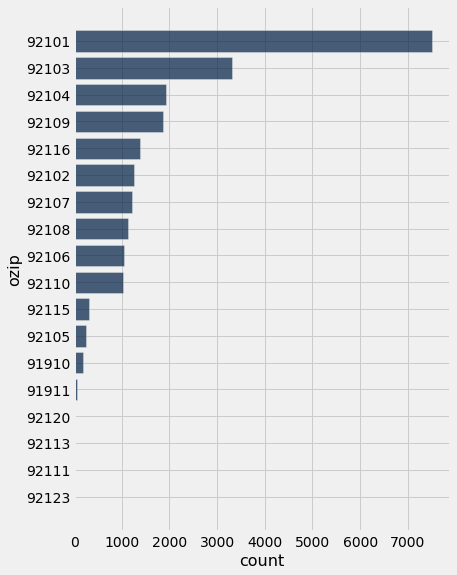

In [89]:
trips_clean.group('ozip').sort('count',descending = True).barh('ozip','count')

In [90]:
new_zips = make_array(91910, 92101, 92102, 92103, 92104, 92105, 92106, 92107,
       92108, 92109, 92110, 92115, 92116)
new_zips

array([91910, 92101, 92102, 92103, 92104, 92105, 92106, 92107, 92108,
       92109, 92110, 92115, 92116])

In [91]:
sensitivity_zip(new_zips)

Optimize a model with 8881 rows, 10368 columns and 34480 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [3e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 8266 rows and 4819 columns
Presolve time: 0.03s
Presolved: 615 rows, 5549 columns, 12946 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 5.857e+03
 Factor NZ  : 2.571e+04 (roughly 3 MBytes of memory)
 Factor Ops : 1.251e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.60402638e+06  4.81820408e+03  1.20e+03 1.08e+01  4.06e+03     0s
   1  -1.39094635e+06  5.40673771e+04  7.78e+02 1.29e+00  9.29e+02     0s

Barrier performed 1 iterations in 0.05 seconds
Barrier solve interrupted - model solved by another algorithm

6950.65

# 5. Model Extensions

In [92]:
#New Parameters:
car_cost = 25000
car_sold = 12500
car_salvaged = 5000
trips_a_car_can_take = 10000
pct_of_cars_in_accident = 1/10000
station_capacity = 10

In [93]:
X3 = {} #number of EV trips from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
R3 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to zipcode  𝑗∈𝑍  at time  𝑡∈𝑇
W3 = {} #number of EVs available at zipcode  𝑖∈𝑍  at time  t∈𝑇

M3 = {} #number of EVs to reposition from zipcode  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
N3 = {} #number of EVs to reposition from charging  𝑖∈𝑍  to charging station  c∈C  at time  𝑡∈𝑇
C3 = {} #number of EVs available at charging station  c∈C  at time  𝑡∈𝑇

model3 = Model('Car2go2')

for t in times:
    for i in zips:
        W3[i,t] = model3.addVar(lb = 0)            
        for j in zips:
                X3[i,j,t] = model3.addVar(lb = 0)
                R3[i,j,t] = model3.addVar(lb = 0)


for t in times:
    for c in chargers:
        C3[c,t] = model3.addVar(lb = 0)
        for i in zips:
            M3[i,c,t] = model3.addVar(lb = 0)
            N3[c,i,t] = model3.addVar(lb = 0)



con_inventory_3 = {}                                            
con_minimum_satifaction_3 = {}
con_maximum_needed_3 = {}
con_repositionning_3 = {}
con_supply_3 = {}
con_charging_vehicles_3 = {}
con_inventory_charging_3 = {}
con_released_3 = {}
con_charging_max_3 = {}
con_charging_station_max_3 = {}



for t in times:

    for i in zips:

        #Inventory Constraint
        if t == 0:
               con_inventory_3[i,0] = model3.addConstr(W3[i,0] == W3[i,23] #Previous Period
                                                           - quicksum(X3[i,j,0] for j in zips) #Cars that left
                                                           + quicksum(X3[j,i,0] for j in zips) #Cars that arrived
                                                           - quicksum(R3[i,j,0] for j in zips) #Cars repositioned away
                                                           + quicksum(R3[j,i,0] for j in zips) #Cars brought back
                                                           - quicksum(M3[i,c,0] for c in chargers) #Cars going to charge
                                                           + quicksum(N3[c,i,0] for c in chargers) #Cars brought from charging
                                                )                                        
        else:

            con_inventory_3[i,t] = model3.addConstr(W3[i,t] == W3[i,t-1] #Previous Period
                                                           - quicksum(X3[i,j,t] for j in zips) #Cars that left
                                                           + quicksum(X3[j,i,t] for j in zips) #Cars that arrived
                                                           - quicksum(R3[i,j,t] for j in zips) #Cars repositioned away
                                                           + quicksum(R3[j,i,t] for j in zips) #Cars brought back
                                                           - quicksum(M3[i,c,t] for c in chargers) #Cars going to charge
                                                           + quicksum(N3[c,i,t] for c in chargers) #Cars brought from charging

                                                )

        for j in zips:
            #Customer Satisfaction Constraints
            try:
                con_minimum_satifaction_3[i,j,t] = model3.addConstr(X3[i,j,t] >= int(np.ceil(demand[i,j,t]*customer_satisfaction_level)))

            except KeyError:
                con_minimum_satifaction_3[i,j,t] = model3.addConstr(X3[i,j,t] == 0)

            try:
                con_maximum_needed_3[i,j,t] = model3.addConstr(X3[i,j,t] <= int(demand[i,j,t]))

            except KeyError:
                con_maximum_needed_3[i,j,t] = model3.addConstr(X3[i,j,t] == 0)                                                  

# Total Cars Constraints
total_cars_3 = model3.addConstr(quicksum(W3[i,0] for i in zips) <= cars_available - quicksum(C3[c,0] for c in chargers))                                                 

for t in times:

    for c in chargers:

        #Inventory Constraints Chargers
        if t == 0:

            con_inventory_charging_3[c,0] = model3.addConstr(C3[c,0] == C3[c,23] #Cars previously there
                                                                      + quicksum(M3[i,c,0] for i in zips) #Cars that are brought to the charging station
                                                                      - quicksum(N3[c,i,0] for i in zips) #Cars that leave the charging station
                                                     )          

        else:

            con_inventory_charging_3[c,t] = model3.addConstr(C3[c,t] == C3[c,t-1] #Cars previously there
                                                                      + quicksum(M3[i,c,t] for i in zips) #Cars that are brought to the charging station
                                                                      - quicksum(N3[c,i,t] for i in zips) #Cars that leave the charging station 
                                                            )
        #Vehicle Released from charge                                                   
        if t == 0:
            con_released_3[c,i,0] = model3.addConstr(quicksum(N3[c,i,0] for i in zips) == quicksum(M3[i,c,20] for i in zips)) 
        elif t == 1:    
            con_released_3[c,i,1] = model3.addConstr(quicksum(N3[c,i,1] for i in zips) == quicksum(M3[i,c,21] for i in zips)) 
        elif t == 2:     
            con_released_3[c,i,2] = model3.addConstr(quicksum(N3[c,i,2] for i in zips) == quicksum(M3[i,c,22] for i in zips))   
        elif t == 3:     
            con_released_3[c,i,3] = model3.addConstr(quicksum(N3[c,i,3] for i in zips) == quicksum(M3[i,c,23] for i in zips))                 
        else:  
            con_released_3[c,i,t] = model3.addConstr(quicksum(N3[c,i,t] for i in zips) == quicksum(M3[i,c,t-4] for i in zips))        


for t in times:
    for i in zips:
        #Vehicles going to charging    
        con_charging_vehicles_3[t] = model3.addConstr(quicksum(M3[i,c,t] for c in chargers) == 0.1*quicksum(X3[j,i,t] for j in zips))                                                       

        
        
for t in times:
    for c in chargers:
        con_charging_station_max_3[t,c] = model3.addConstr(C3[c,t] <= station_capacity)



In [94]:
#objective function
obj3 = ( quicksum(X3[i,j,t]*Price[i,j,t]  for i in zips for j in zips for t in times) #Revenue
       - quicksum(R3[i,j,t]*Costs[i,j] for i in zips for j in zips for t in times) # Initial Reposition Costs
       - quicksum((M3[i,c,t]*Costs_Charging[i,c] + M3[i,c,t]*cost_electricity) for i in zips for c in chargers for t in times) #Reposition to charger costs
       - quicksum(N3[c,i,t]*Costs_Charging[i,c] for c in chargers for i in zips for t in times) #Reposition from charger Costs
        
       - quicksum(X3[i,j,t]*((car_cost-car_sold)/trips_a_car_can_take) for i in zips for j in zips for t in times) #Xtrips car takes
       - quicksum(R3[i,j,t]*((car_cost-car_sold)/trips_a_car_can_take) for i in zips for j in zips for t in times) #Xtrips car takes
       - quicksum(M3[i,c,t]*((car_cost-car_sold)/trips_a_car_can_take) for i in zips for j in zips for t in times) #Xtrips car takes
       - quicksum(N3[c,i,t]*((car_cost-car_sold)/trips_a_car_can_take) for i in zips for j in zips for t in times) #Xtrips car takes

        
       - quicksum(X3[i,j,t]*((pct_of_cars_in_accident)*(car_cost-car_salvaged)) for i in zips for j in zips for t in times)
       - quicksum(R3[i,j,t]*((pct_of_cars_in_accident)*(car_cost-car_salvaged)) for i in zips for j in zips for t in times)
       - quicksum(M3[i,c,t]*((pct_of_cars_in_accident)*(car_cost-car_salvaged)) for i in zips for j in zips for t in times)
       - quicksum(N3[c,i,t]*((pct_of_cars_in_accident)*(car_cost-car_salvaged)) for i in zips for j in zips for t in times)

       )

In [95]:
model3.setObjective(obj3, GRB.MAXIMIZE)
model3.optimize()

Optimize a model with 16633 rows, 18648 columns and 62877 nonzeros
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [3e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 15891 rows and 9025 columns
Presolve time: 0.05s
Presolved: 742 rows, 9623 columns, 21424 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 8.473e+03
 Factor NZ  : 3.353e+04 (roughly 4 MBytes of memory)
 Factor Ops : 1.994e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.76810850e+06  1.84860156e+04  3.23e+02 0.00e+00  1.28e+03     0s
   1  -1.12045174e+06  2.53613959e+04  9.58e+01 1.29e+00  1.89e+02     0s
   2  -9.28493366e+04  2.11250926e+04  6.41e+00 2.61e-01  1.57e+01     0s
   3  -1.16368757e+03  1.26894671

In [96]:
round(model3.objVal,2)

4612.28